# Análisis Exploratorio Inicial: tabla fact orders
# Dataset: Brazilian E-Commerce Public Dataset by Olist
[https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce]

Yasmin Ohana - legajo: 65098

Julia Sexe - legajo: 65669

Alexis Florian Rehmann - legajo: 61251

##Carga de librerías necesarias.

In [1]:
import os, json, pathlib
import zipfile, pathlib, re
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import boxcox, zscore
from scipy.special import inv_boxcox
from scipy.stats import yeojohnson
from scipy.stats import chi2
import missingno as msno
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
import statsmodels.api as sm

##Ingesta de los datos desde Kaggle.
Aclaración: los archivos crudos están subidos en el repositorio de GitHub pero no realizamos la ingesta desde ahí ya que el archivo "Olist_geolocation_dataset.csv" era muy pesado y no permitía ser subido al repositorio.

In [2]:
!pip -q install kaggle

KAGGLE_USERNAME = "yasminohana1"
KAGGLE_KEY      = "4b30102e8deedd1447edf89efab04761"

os.environ["KAGGLE_USERNAME"] = KAGGLE_USERNAME
os.environ["KAGGLE_KEY"] = KAGGLE_KEY

path = pathlib.Path("~/.kaggle").expanduser()
path.mkdir(parents=True, exist_ok=True)
with open(path / "kaggle.json", "w") as f:
    json.dump({"username": KAGGLE_USERNAME, "key": KAGGLE_KEY}, f)

!chmod 600 ~/.kaggle/kaggle.json

In [3]:
def kaggle_slug_from_url(url_or_slug: str) -> str:
    m = re.search(r"kaggle\.com/datasets/([^/?#]+/[^/?#]+)", url_or_slug)
    return m.group(1) if m else url_or_slug.strip()

def kaggle_download(url_or_slug: str, dest="/content/data"):
    slug = kaggle_slug_from_url(url_or_slug)
    dest = pathlib.Path(dest)
    dest.mkdir(parents=True, exist_ok=True)
    print(f"Descargando: {slug} → {dest}")
    !kaggle datasets download -d {slug} -p {dest} -q
    # descomprimir todos los .zip que queden en dest
    for z in dest.glob("*.zip"):
        with zipfile.ZipFile(z) as zf:
            zf.extractall(dest)
        z.unlink()
    print("Listo. Archivos en:", dest)
    return dest

In [4]:
olist_dir = kaggle_download("https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce",
                            dest="/content/olist")
!ls -1 {olist_dir}

Descargando: olistbr/brazilian-ecommerce → /content/olist
Dataset URL: https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce
License(s): CC-BY-NC-SA-4.0
Listo. Archivos en: /content/olist
olist_customers_dataset.csv
olist_geolocation_dataset.csv
olist_order_items_dataset.csv
olist_order_payments_dataset.csv
olist_order_reviews_dataset.csv
olist_orders_dataset.csv
olist_products_dataset.csv
olist_sellers_dataset.csv
product_category_name_translation.csv


In [5]:
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

DATA = Path("/content/olist")

date_cols_orders = [
    "order_purchase_timestamp","order_approved_at",
    "order_delivered_carrier_date","order_delivered_customer_date",
    "order_estimated_delivery_date"
]

orders   = pd.read_csv(DATA/"olist_orders_dataset.csv", parse_dates=date_cols_orders)
payments = pd.read_csv(DATA/"olist_order_payments_dataset.csv")
reviews  = pd.read_csv(DATA/"olist_order_reviews_dataset.csv",
                       parse_dates=["review_creation_date","review_answer_timestamp"])
customers= pd.read_csv(DATA/"olist_customers_dataset.csv")
geo      = pd.read_csv(DATA/"olist_geolocation_dataset.csv")

##Análisis exploratorio inicial de los datos.

En esta sección se realiza el análisis exploratorio sobre las tablas que influyen en la fact orders.

###Forma y tamaño del dataset. Análisis de valores únicos.

In [6]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [7]:
print("geo – filas totales:", f"{len(geo):,}")
pref = geo['geolocation_zip_code_prefix']
print("prefijos únicos:", f"{pref.nunique():,}")
dup = geo.groupby('geolocation_zip_code_prefix').size()
print("% de prefijos con >1 fila:", round((dup > 1).mean()*100, 1), "%")

geo – filas totales: 1,000,163
prefijos únicos: 19,015
% de prefijos con >1 fila: 94.5 %


In [8]:
orders.head()
orders.info()
orders.describe()
for i in orders.columns:
  print(i, orders[i].isnull().sum())

# aca hay nulos, vamos a imputar más adelante

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB
order_id 0
customer_id 0
order_status 0
order_purchase_timestamp 0
order_approved_at 160
order_delivered_carrier_date 1783
order_delivered_customer_date 2965
order

In [9]:
orders['order_status'].value_counts()

,count
order_status,
delivered,96478
shipped,1107
canceled,625
unavailable,609
invoiced,314
processing,301
created,5
approved,2


In [10]:
payments.info()
payments.describe()
for i in payments.columns:
  print(i, payments[i].isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB
order_id 0
payment_sequential 0
payment_type 0
payment_installments 0
payment_value 0


In [11]:
payments['payment_installments'].value_counts()

,count
payment_installments,
1,52546
2,12413
3,10461
4,7098
10,5328
5,5239
8,4268
6,3920
7,1626


In [12]:
payments['payment_type'].value_counts()

,count
payment_type,
credit_card,76795
boleto,19784
voucher,5775
debit_card,1529
not_defined,3


In [13]:
payments['payment_value'].value_counts()

,count
payment_value,
50.00,324
20.00,274
100.00,255
77.57,250
35.00,165
...,...
166.54,1
399.22,1
73.02,1


In [14]:
payments['payment_sequential'].value_counts()

,count
payment_sequential,
1,99360
2,3039
3,581
4,278
5,170
6,118
7,82
8,54
9,43


In [15]:
reviews.info()
reviews.describe()
for i in reviews.columns:
  print(i, reviews[i].isnull().sum())

# tenemos valores nulos en los titulos y mensajes, pero como son textos decidimos no entrar en el mundo de procesamiento de lenguaje natural.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   review_id                99224 non-null  object        
 1   order_id                 99224 non-null  object        
 2   review_score             99224 non-null  int64         
 3   review_comment_title     11568 non-null  object        
 4   review_comment_message   40977 non-null  object        
 5   review_creation_date     99224 non-null  datetime64[ns]
 6   review_answer_timestamp  99224 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(4)
memory usage: 5.3+ MB
review_id 0
order_id 0
review_score 0
review_comment_title 87656
review_comment_message 58247
review_creation_date 0
review_answer_timestamp 0


In [16]:
reviews['review_score'].value_counts()

,count
review_score,
5,57328
4,19142
1,11424
3,8179
2,3151


In [17]:
reviews['review_answer_timestamp'].nunique()

98248

In [18]:
reviews['review_answer_timestamp'].unique() ##todas fechas

<DatetimeArray>
['2018-01-18 21:46:59', '2018-03-11 03:05:13', '2018-02-18 14:36:24',
 '2017-04-21 22:02:06', '2018-03-02 10:26:53', '2018-04-16 00:39:37',
 '2017-07-18 19:30:34', '2018-08-14 21:36:06', '2017-05-18 12:05:37',
 '2018-05-23 16:45:47',
 ...
 '2018-05-26 21:24:06', '2018-05-20 21:51:06', '2018-05-10 14:37:03',
 '2017-12-14 11:09:36', '2018-04-30 01:18:57', '2018-07-14 17:18:30',
 '2017-12-11 20:06:42', '2018-03-23 09:10:43', '2018-07-02 12:59:13',
 '2017-07-03 21:01:49']
Length: 98248, dtype: datetime64[ns]

In [19]:
customers.info()
customers.describe()
for i in customers.columns:
  print(i, customers[i].isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
customer_id 0
customer_unique_id 0
customer_zip_code_prefix 0
customer_city 0
customer_state 0


In [20]:
customers['customer_unique_id'].value_counts()

,count
customer_unique_id,
8d50f5eadf50201ccdcedfb9e2ac8455,17
3e43e6105506432c953e165fb2acf44c,9
ca77025e7201e3b30c44b472ff346268,7
1b6c7548a2a1f9037c1fd3ddfed95f33,7
6469f99c1f9dfae7733b25662e7f1782,7
...,...
4f83c83b7ff5b544a8c75dcb8ad66e2e,1
3fe413dde400746c53c5d0d38b266ca2,1
289e1d1ce11a14bb169775d58ad2f1c2,1


In [21]:
customers.shape

(99441, 5)

In [22]:
customers['customer_id'].nunique()

99441

In [23]:
geo.info()
geo.describe()
for i in geo.columns:
  print(i, geo[i].isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB
geolocation_zip_code_prefix 0
geolocation_lat 0
geolocation_lng 0
geolocation_city 0
geolocation_state 0


In [24]:
pays_per_order  = payments.groupby("order_id").size()
revs_per_order  = reviews.groupby("order_id").size()

print("Pagos por orden  → mediana:", int(pays_per_order.median()),  "| máx:", int(pays_per_order.max()))
print("Reviews por orden→ mediana:", int(revs_per_order.median()),   "| máx:", int(revs_per_order.max()))

Pagos por orden  → mediana: 1 | máx: 29
Reviews por orden→ mediana: 1 | máx: 3


In [25]:
orders_with_multiple_reviews = revs_per_order[revs_per_order > 1]

if len(orders_with_multiple_reviews) > 0:
    print(f"There are {len(orders_with_multiple_reviews)} orders with more than one review.")
else:
    print("There are no orders with more than one review.")

There are 547 orders with more than one review.


In [26]:
##sumo monto total, tomo la mayor cant de cuotas IGUAL VER, SI ES LA MAYOR O LA SUMA y el metodo mas frecuente
def modo(s):
    m = s.mode(dropna=True)
    return m.iloc[0] if len(m) else np.nan

pay_agg = (payments
           .groupby("order_id", as_index=False)
           .agg(payment_value_total=("payment_value","sum"),
                payment_installments_max=("payment_installments","max"),
                payment_type_mode=("payment_type", modo)))

In [27]:
##con las reviews me quedo con la mas reciente

reviews_sorted = reviews.sort_values(["order_id","review_creation_date"])
rev_agg = (reviews_sorted
           .groupby("order_id", as_index=False)
           .agg(review_score=("review_score","last"),
                review_comment_title=("review_comment_title","last"),
                review_comment_message=("review_comment_message","last"),
                review_creation_date=("review_creation_date","last"),
                review_answer_timestamp=("review_answer_timestamp","last")))

In [28]:
geo_agg = (geo.groupby("geolocation_zip_code_prefix", as_index=False)
             .agg(geolocation_lat=("geolocation_lat","mean"),
                  geolocation_lng=("geolocation_lng","mean"),
                  geolocation_city=("geolocation_city", modo),
                  geolocation_state=("geolocation_state", modo)))

In [29]:
##clientes + geo
cust_geo = customers.merge(
    geo_agg.rename(columns={
        "geolocation_zip_code_prefix":"customer_zip_code_prefix",
        "geolocation_lat":"customer_lat","geolocation_lng":"customer_lng",
        "geolocation_city":"customer_geo_city","geolocation_state":"customer_geo_state"
    }),
    on="customer_zip_code_prefix", how="left"
)

In [30]:
##orden con cliente y geo con pagos agg y con review agg
fact_orders = (orders
               .merge(cust_geo, on="customer_id", how="left")
               .merge(pay_agg, on="order_id",   how="left")
               .merge(rev_agg, on="order_id",   how="left"))

assert fact_orders["order_id"].is_unique
print("fact_orders:", fact_orders.shape)

fact_orders: (99441, 24)


In [31]:
# Días de entrega (si hay fechas)
fact_orders["delivery_days"] = (
    fact_orders["order_delivered_customer_date"] - fact_orders["order_purchase_timestamp"]
).dt.days

# % de atraso (entregado después de la fecha estimada)
fact_orders["is_late"] = (
    fact_orders["order_delivered_customer_date"] > fact_orders["order_estimated_delivery_date"]
).astype("Int8")

print("Mediana días de entrega (válidos):", fact_orders["delivery_days"].dropna().median())
print("% órdenes 'late':", round(fact_orders["is_late"].mean()*100, 2))

# % de órdenes con review
print("% órdenes con review:", round(fact_orders["review_score"].notna().mean()*100, 2))

Mediana días de entrega (válidos): 10.0
% órdenes 'late': 7.87
% órdenes con review: 99.23


In [32]:
print("Shape of original orders dataframe:", orders.shape)
print("Shape of fact_orders dataframe:", fact_orders.shape)

Shape of original orders dataframe: (99441, 8)
Shape of fact_orders dataframe: (99441, 26)


###Estadísticos principales.

In [33]:
fact_orders.describe()

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_zip_code_prefix,customer_lat,customer_lng,payment_value_total,payment_installments_max,review_score,review_creation_date,review_answer_timestamp,delivery_days,is_late
count,99441,99281,97658,96476,99441,99441.000000,99163.000000,99163.000000,99440.000000,99440.000000,98673.000000,98673,98673,96476.000000,99441.0
mean,2017-12-31 08:43:12.776581120,2017-12-31 18:35:24.098800128,2018-01-04 21:49:48.138278656,2018-01-14 12:09:19.035542272,2018-01-24 03:08:37.730111232,35137.474583,-21.191224,-46.175442,160.990267,2.930521,4.086336,2018-01-13 04:44:29.763765248,2018-01-16 08:19:54.802124032,12.094086,0.07871
min,2016-09-04 21:15:19,2016-09-15 12:16:38,2016-10-08 10:34:01,2016-10-11 13:46:32,2016-09-30 00:00:00,1003.000000,-33.689948,-72.668881,0.000000,0.000000,1.000000,2016-10-02 00:00:00,2016-10-07 18:32:28,0.000000,0.0
25%,2017-09-12 14:46:19,2017-09-12 23:24:16,2017-09-15 22:28:50.249999872,2017-09-25 22:07:22.249999872,2017-10-03 00:00:00,11347.000000,-23.589378,-48.097950,62.010000,1.000000,4.000000,2017-09-23 00:00:00,2017-09-27 14:50:01,6.000000,0.0
50%,2018-01-18 23:04:36,2018-01-19 11:36:13,2018-01-24 16:10:58,2018-02-02 19:28:10.500000,2018-02-15 00:00:00,24416.000000,-22.924970,-46.630647,105.290000,2.000000,5.000000,2018-02-02 00:00:00,2018-02-05 10:51:54,10.000000,0.0
75%,2018-05-04 15:42:16,2018-05-04 20:35:10,2018-05-08 13:37:45,2018-05-15 22:48:52.249999872,2018-05-25 00:00:00,58900.000000,-20.139828,-43.598897,176.970000,4.000000,5.000000,2018-05-16 00:00:00,2018-05-20 13:59:01,15.000000,0.0
max,2018-10-17 17:30:18,2018-09-03 17:40:06,2018-09-11 19:48:28,2018-10-17 13:22:46,2018-11-12 00:00:00,99990.000000,42.184003,-8.723762,13664.080000,24.000000,5.000000,2018-08-31 00:00:00,2018-10-29 12:27:35,209.000000,1.0
std,NaN,NaN,NaN,NaN,NaN,29797.938996,5.608637,4.056067,221.951257,2.715685,1.347625,NaN,NaN,9.551746,0.269287


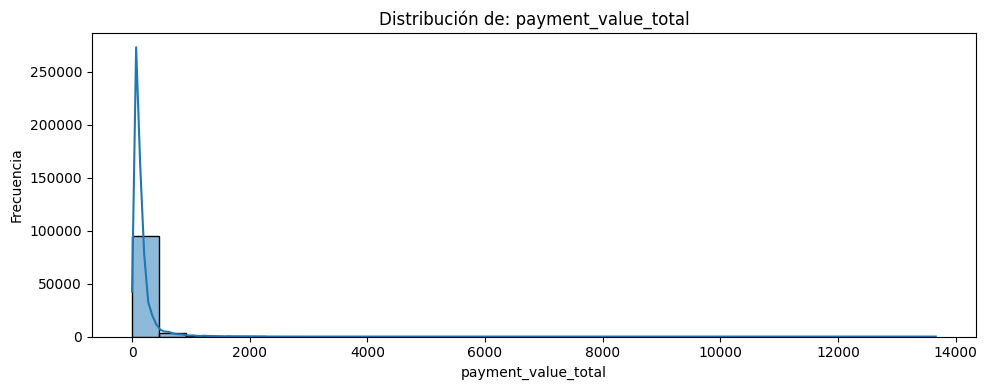

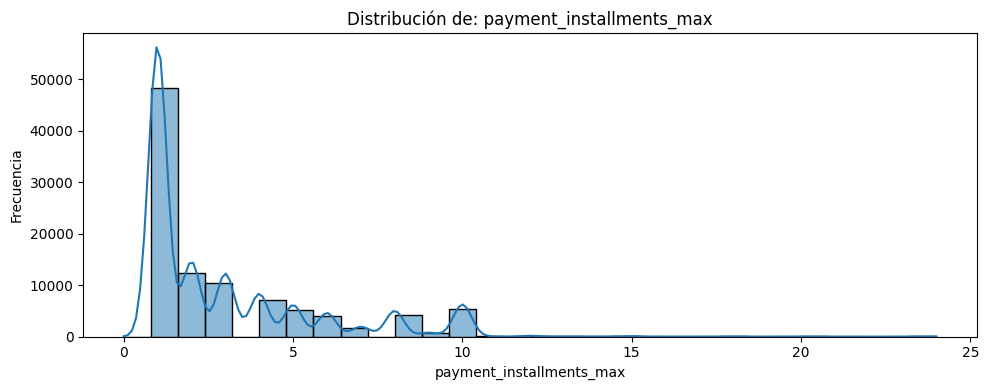

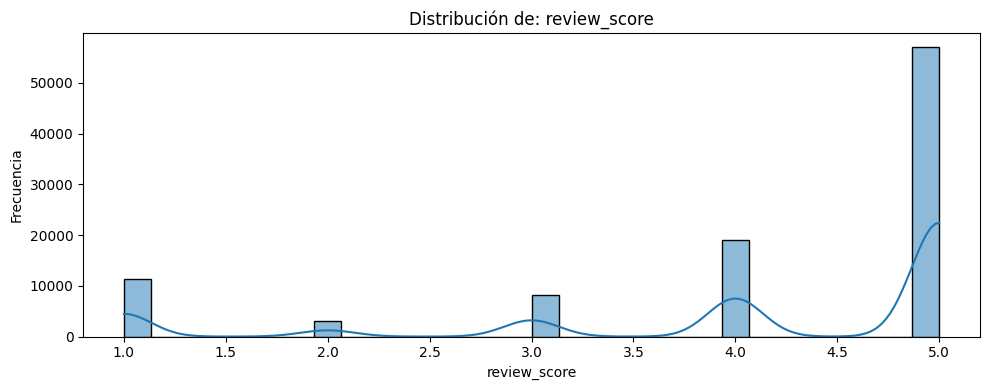

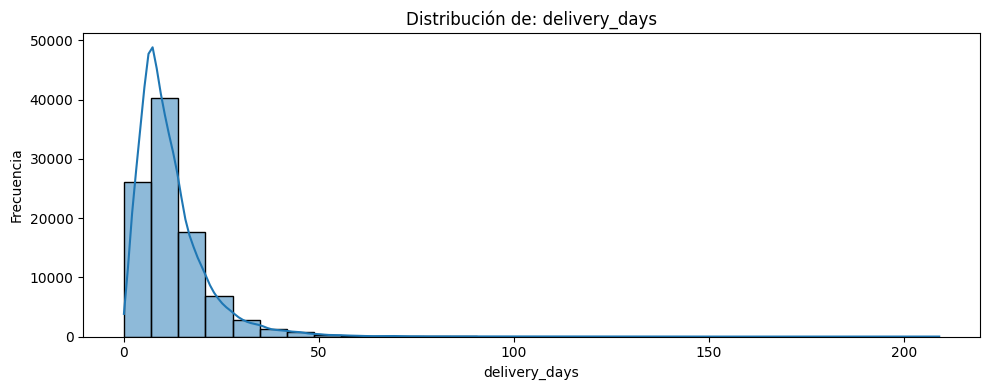

In [34]:
# Define numerical columns for fact_orders
cols_numericas_fact_orders = fact_orders.select_dtypes(include=['number']).columns.tolist()

# Exclude ID columns, binary variables, and transformation columns from fact_orders
exclude_from_hist_orders = [
    'order_id', 'customer_id', 'customer_unique_id', 'is_late', 'customer_zip_code_prefix',
    'boxcox_payment_value_total', 'z_score_payment_value_total_boxcox', 'z_score_payment_value_total',
    'boxcox_imputed_payment_value_total', 'cleaned_payment_value_total',
    'yeojohnson_payment_value_total', 'z_score_payment_value_total_yeojohnson', 'payment_value_total_orig',
    'boxcox_delivery_days', 'z_score_delivery_days_boxcox', 'z_score_delivery_days',
    'boxcox_imputed_delivery_days', 'cleaned_delivery_days',
    'yeojohnson_delivery_days', 'z_score_delivery_days_yeojohnson', 'delivery_days_orig',
    'customer_lat', 'customer_lng' # Exclude geo coordinates for general distribution plots if they are not the focus
]

# Filter for relevant numerical columns
plot_cols_orders = [col for col in cols_numericas_fact_orders if col not in exclude_from_hist_orders and not col.startswith(('boxcox_', 'yeojohnson_', 'z_score_', 'cleaned_', 'delivery_days_'))]

# histograma de variables numericas
for col in plot_cols_orders:
    plt.figure(figsize=(10,4))
    sns.histplot(fact_orders[col].dropna(), bins=30, kde=True)
    plt.title(f"Distribución de: {col}")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()

Bar charts for discrete numerical variables in fact_orders:


/tmp/ipython-input-108228686.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=fact_orders.dropna(subset=[col]), x=col, palette='viridis')


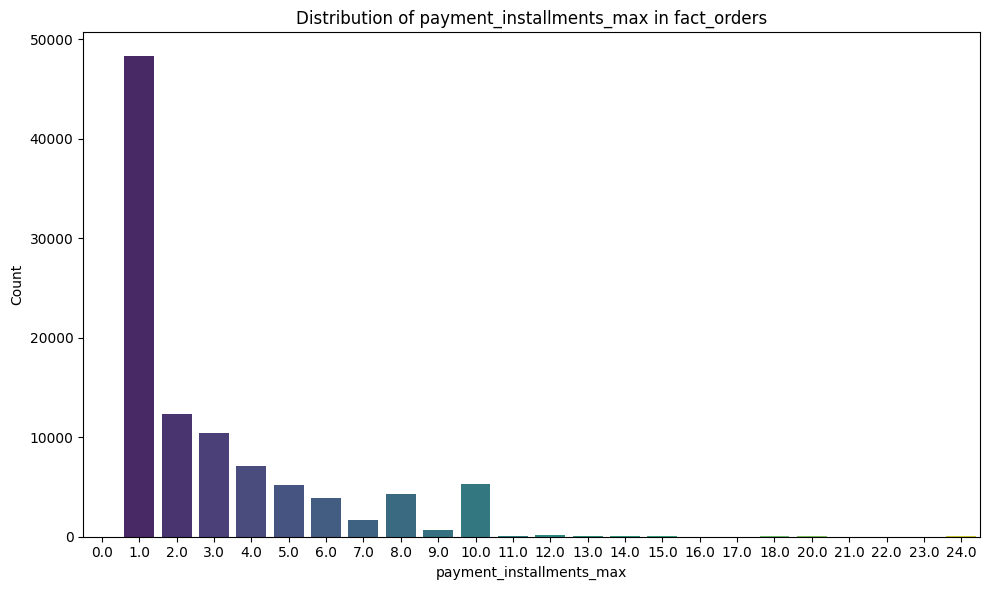

/tmp/ipython-input-108228686.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=fact_orders.dropna(subset=[col]), x=col, palette='viridis')


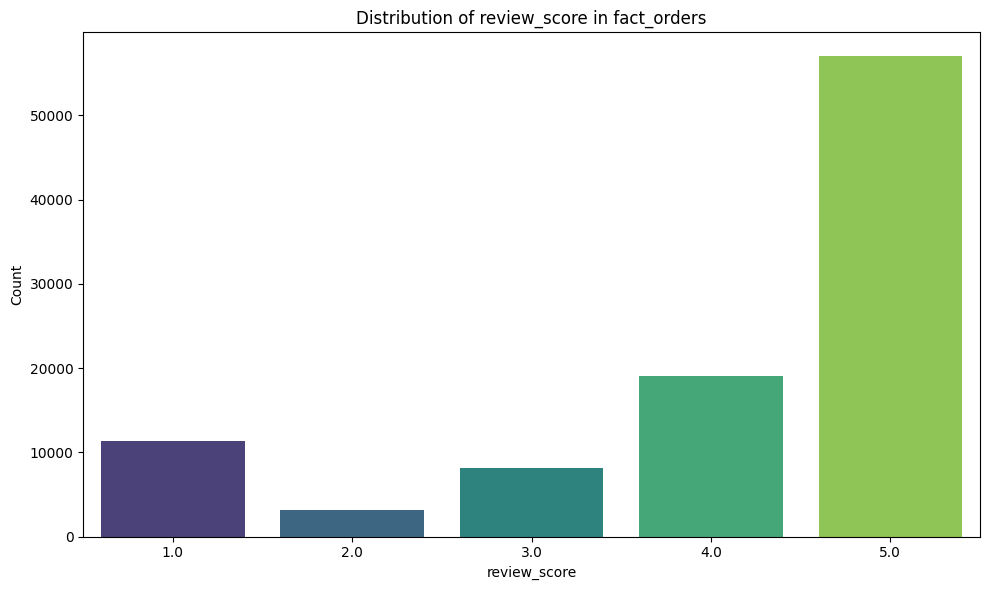

In [35]:
discrete_for_bar_chart_orders = ['payment_installments_max', 'review_score']

print("Bar charts for discrete numerical variables in fact_orders:")
for col in discrete_for_bar_chart_orders:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=fact_orders.dropna(subset=[col]), x=col, palette='viridis')
    plt.title(f'Distribution of {col} in fact_orders')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

###Análisis de duplicados, nulos y outliers.

In [36]:
print("Checking for duplicates in original dataframes:")
print("Orders duplicates:", orders.duplicated().sum())
print("Payments duplicates:", payments.duplicated().sum())
print("Reviews duplicates:", reviews.duplicated().sum())
print("Customers duplicates:", customers.duplicated().sum())
print("Geo duplicates:", geo.duplicated().sum())

print("\nChecking for duplicates in aggregated dataframes:")
print("Fact Orders duplicates:", fact_orders.duplicated().sum())

Checking for duplicates in original dataframes:
Orders duplicates: 0
Payments duplicates: 0
Reviews duplicates: 0
Customers duplicates: 0
Geo duplicates: 261831

Checking for duplicates in aggregated dataframes:
Fact Orders duplicates: 0


In [37]:
def top_nulls(df, k=10):
    return (df.isna().mean().mul(100).round(2)
            .sort_values(ascending=False).head(k))

print("Nulos fact_orders (top 10):\n", top_nulls(fact_orders))

Nulos fact_orders (top 10):
 review_comment_title             88.38
review_comment_message           58.93
order_delivered_customer_date     2.98
delivery_days                     2.98
order_delivered_carrier_date      1.79
review_score                      0.77
review_answer_timestamp           0.77
review_creation_date              0.77
customer_lat                      0.28
customer_lng                      0.28
dtype: float64


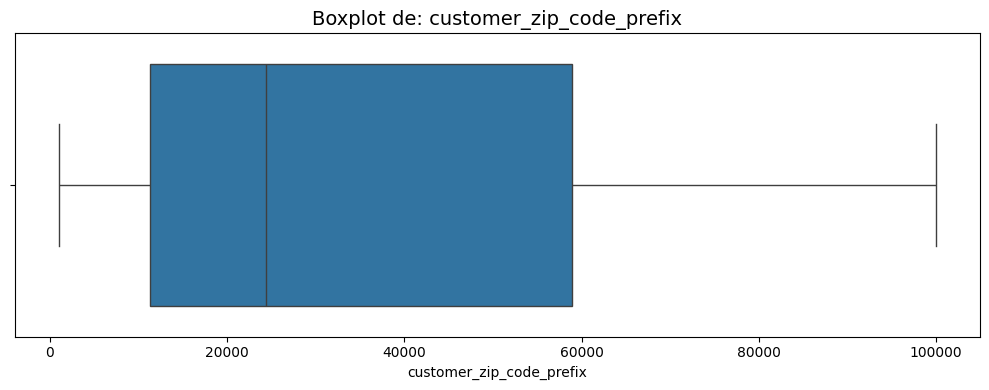

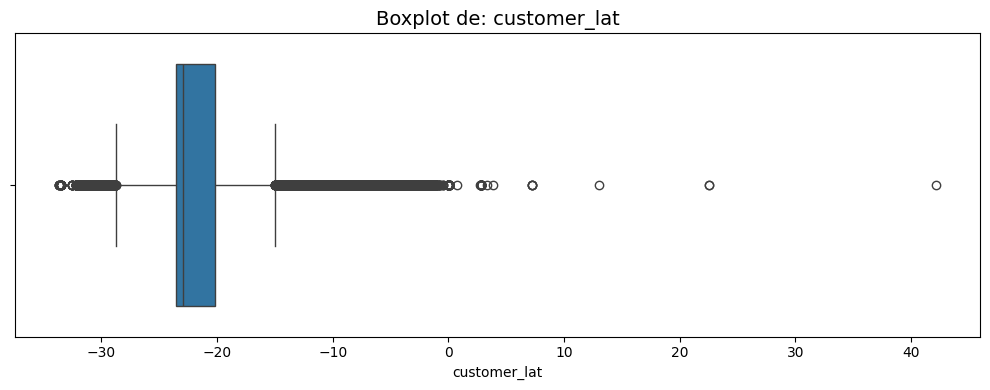

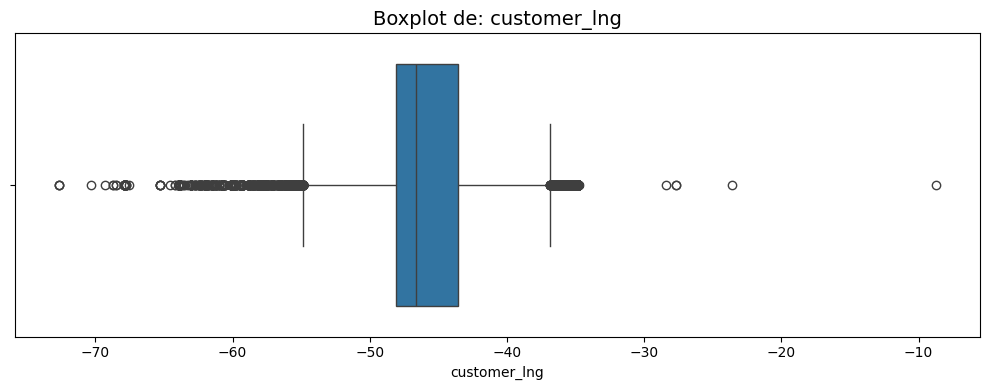

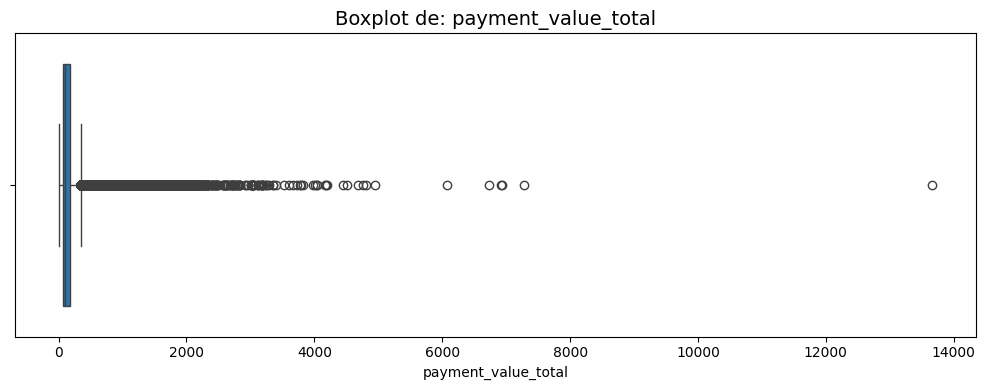

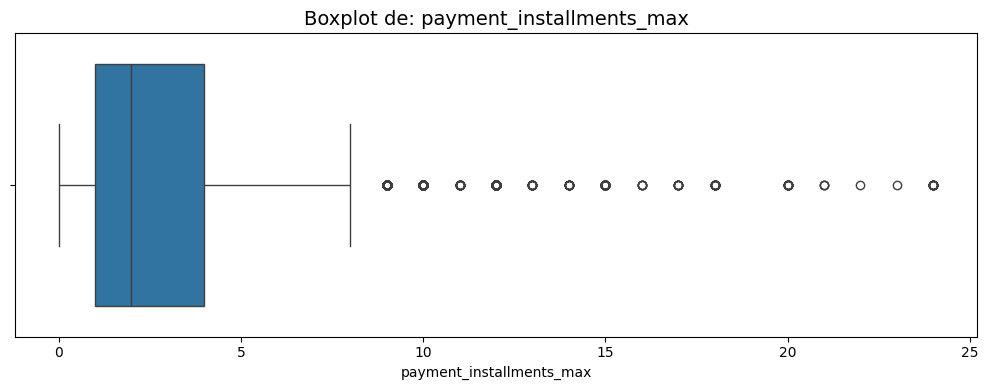

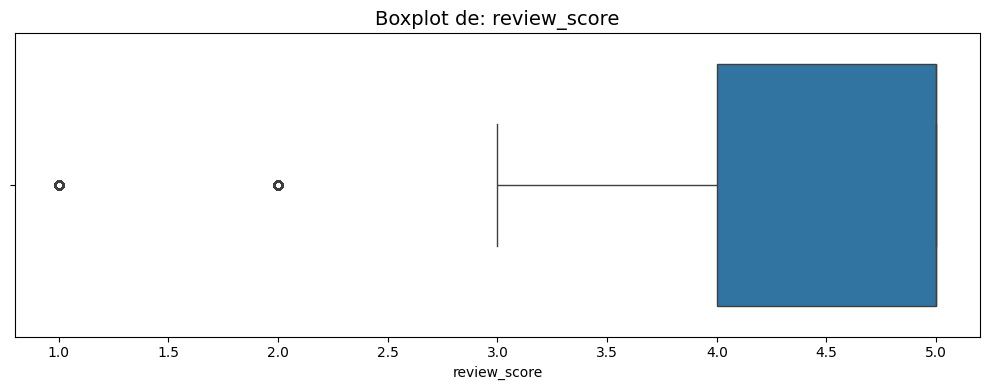

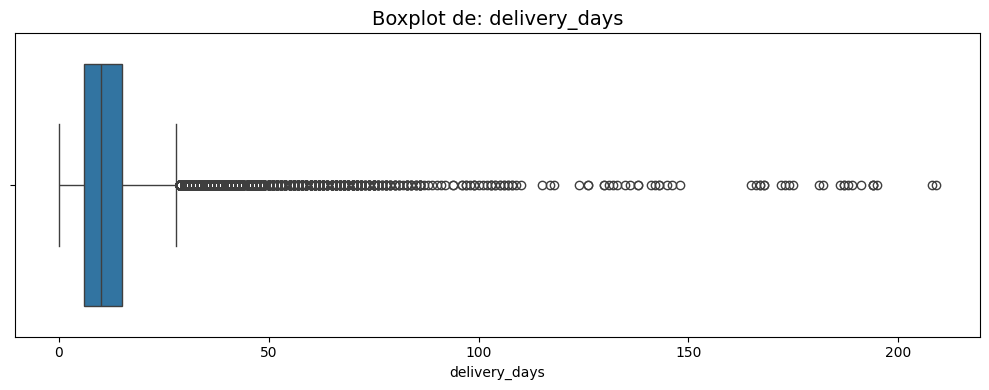

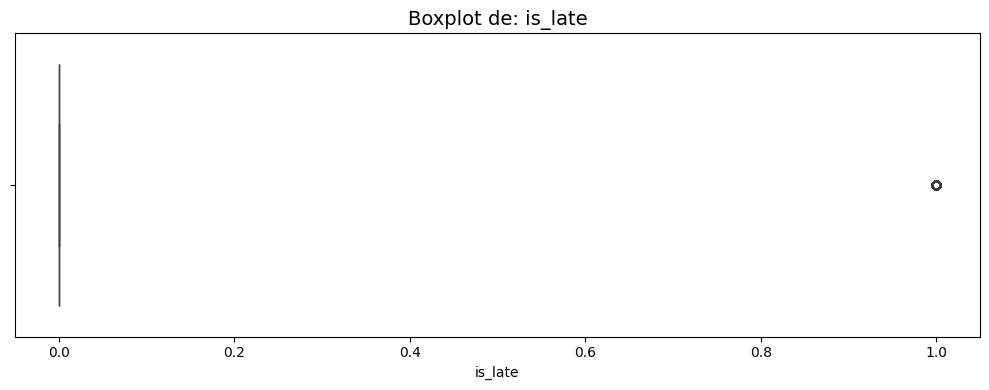

In [38]:
# boxplots para detectar outliers y ver la distribucion de las variables

cols_numericas_fact_orders = fact_orders.select_dtypes(include='number').columns

for col in cols_numericas_fact_orders:
    plt.figure(figsize=(10, 4))
    sns.boxplot(data=fact_orders, x=col)
    plt.title(f"Boxplot de: {col}", fontsize=14)
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

In [39]:
# funcion para detectar outliers usando IQR
def detectar_outliers_iqr(df, columna, severos = False):
    if severos == True:
      sep = 3
    else:
      sep = 1.5
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - sep * IQR
    limite_superior = Q3 + sep * IQR
    outliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]
    return outliers.index

qOutliers = 0
qOutliersSeveros = 0
df_outliers_severos = pd.DataFrame()

cols_numericas_fact_orders_no_geo = [col for col in cols_numericas_fact_orders if 'lat' not in col and 'lng' not in col]

for col in cols_numericas_fact_orders_no_geo:
    outliers = detectar_outliers_iqr(fact_orders, col)
    outliers_severos = detectar_outliers_iqr(fact_orders, col, severos=True)
    print(f"{col}: {len(outliers)} outliers totales ({len(outliers) / len(fact_orders) * 100:.2f}%)",
          f" y {len(outliers_severos)} outliers severos ({len(outliers_severos) / len(fact_orders) * 100:.2f}%)",sep='')
    qOutliers+= len(outliers)
    qOutliersSeveros+= len(outliers_severos)
    outliers_severos = pd.Series(outliers_severos.tolist())
    df_outliers_severos = pd.concat([df_outliers_severos,outliers_severos])

print(f'En total hay {qOutliers} outliers y {qOutliersSeveros} outliers severos')

customer_zip_code_prefix: 0 outliers totales (0.00%) y 0 outliers severos (0.00%)
payment_value_total: 7866 outliers totales (7.91%) y 3999 outliers severos (4.02%)
payment_installments_max: 6300 outliers totales (6.34%) y 169 outliers severos (0.17%)
review_score: 14493 outliers totales (14.57%) y 0 outliers severos (0.00%)
delivery_days: 5025 outliers totales (5.05%) y 1320 outliers severos (1.33%)
En total hay 33684 outliers y 5488 outliers severos


##Preprocesamiento inicial

###Tratamiento de nulos, duplicados y outliers. Definición de criterios de imputación y justificación.

En el caso de la latitud y longitud, decidimos excluirlos del analisis de outliers porque son direcciones y consideramos que no debiamos incluirlos.

In [40]:
fact_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
 8   customer_unique_id             99441 non-null  object        
 9   customer_zip_code_prefix       99441 non-null  int64         
 10  customer_city                  99441 non-null  object        
 11  customer_state 

Analyzing fact_orders:
Variable: payment_value_total
Shapiro-Wilk p-Valor: 4.035088331009864e-79
Variable: delivery_days
Shapiro-Wilk p-Valor: 4.856567782340027e-72


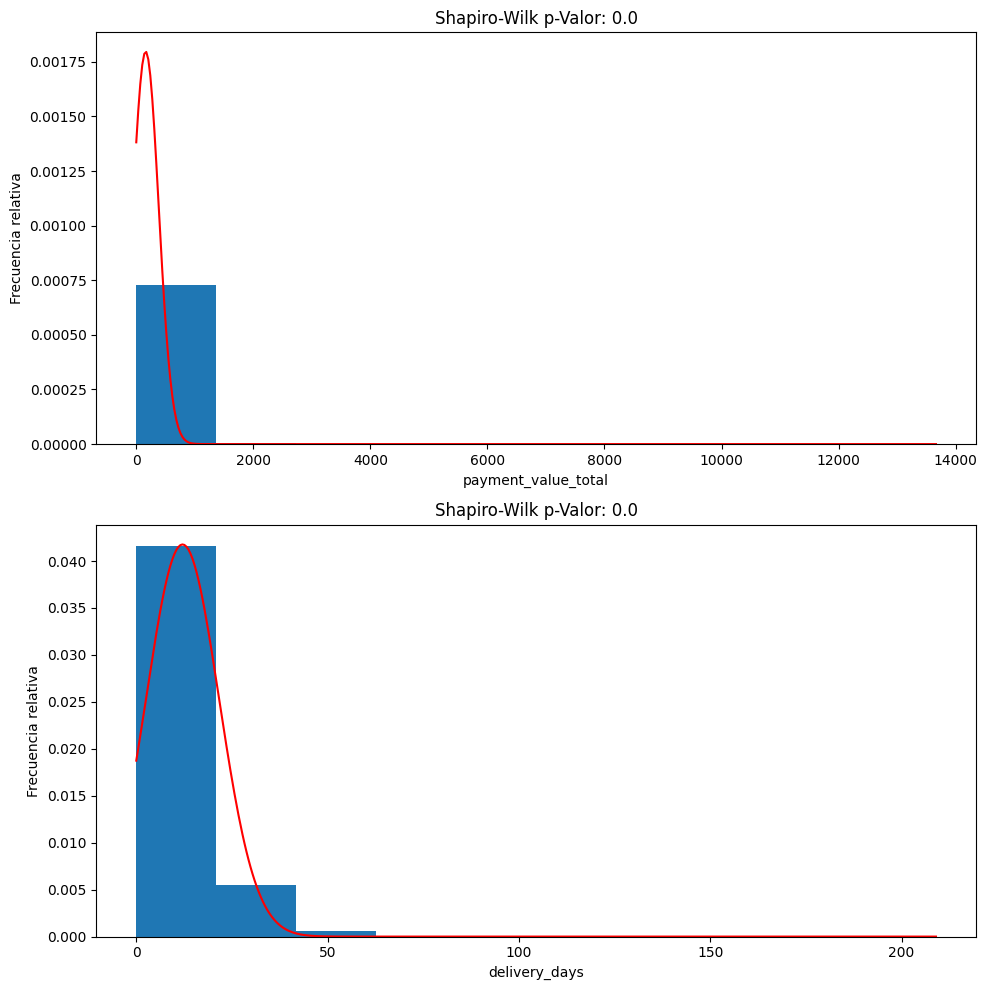

In [41]:
# analizamos los outliers de las variables cuantitativas continuas
# para eso, primero tenemos que ver si son normales

# H0 es que la variable sigue una distribucion normal
# H1 es que no sigue una distribucion normal

# CONTINUAS:
continuous_cols_orders = ['payment_value_total', 'delivery_days']


print("Analyzing fact_orders:")
fig_orders, ax_orders = plt.subplots(len(continuous_cols_orders), 1, figsize=(10, 5 * len(continuous_cols_orders)))

for i, col in enumerate(continuous_cols_orders):
  data_filtered = fact_orders[col].replace([np.inf, -np.inf], np.nan).dropna()

  if len(data_filtered) > 0:
    muVar, sVar = stats.norm.fit(data_filtered)
    mAux = data_filtered.min()
    MAux = data_filtered.max()

    if len(data_filtered) > 5000:
        pvAux = stats.shapiro(data_filtered.sample(5000, random_state=42)).pvalue
    else:
        pvAux = stats.shapiro(data_filtered).pvalue

    print(f"Variable: {col}")
    print(f"Shapiro-Wilk p-Valor: {pvAux}")

    xseq = np.linspace(mAux, MAux, 400)
    yseq = stats.norm(muVar, sVar).pdf(xseq)

    ax_orders[i].hist(data_filtered, density=True)
    ax_orders[i].plot(xseq, yseq, c="r")
    ax_orders[i].set_ylabel("Frecuencia relativa")
    ax_orders[i].set_xlabel(col)
    ax_orders[i].set_title(f"Shapiro-Wilk p-Valor: {np.round(pvAux, 10)}")
  else:
      print(f"Variable: {col} has no valid data after filtering.")


fig_orders.tight_layout()
plt.show()

In [42]:
# analizamos los outliers de las variables cuantitativas continuas
# ahora, como NO son normales, aplicamos boxcox y luego buscamos los outliers con z score y umbral de 4 desviaciones estandar sobre la media

continuous_cols_orders = ['payment_value_total', 'delivery_days']



def aplicar_boxcox_z_score_outliers(df, cols, z_thresh=4.0):  # cols son las columnas que le paso
    for col in cols:
        if col not in df.columns:
            print(f"Column '{col}' not found in the DataFrame. Skipping.")
            continue

        # 1) Transformación Box–Cox (requiere > 0)
        # Filter out non-positive values for Box-Cox
        data_positive = df[col].dropna()
        if (data_positive <= 0).any():
            print(f"Column '{col}' contains non-positive values. Cannot apply Box-Cox directly.")
            # You might consider a different transformation or handle these values
            continue

        sin_na = data_positive
        data_bc, lambda_bc = boxcox(sin_na)

        # Alinear índices
        df[f"boxcox_{col}"] = np.nan
        df.loc[sin_na.index, f"boxcox_{col}"] = data_bc

        # 2) Z-score en Box–Cox
        df[f"z_score_{col}_boxcox"] = zscore(df[f"boxcox_{col}"], nan_policy="omit")
        mask_out_bc = np.abs(df[f"z_score_{col}_boxcox"]) > z_thresh

        # 3) Z-score en escala original (solo para informar)
        df[f"z_score_{col}"] = zscore(df[col], nan_policy="omit")
        mask_out_raw = np.abs(df[f"z_score_{col}"]) > z_thresh

        # 4) Imputación: mediana en espacio Box–Cox (sobre NO-outliers)
        median_bc = np.median(df.loc[~mask_out_bc, f"boxcox_{col}"].dropna()) #dropna() added
        df[f"boxcox_imputed_{col}"] = df[f"boxcox_{col}"].copy()
        df.loc[mask_out_bc, f"boxcox_imputed_{col}"] = median_bc

        # 5) Volver a escala original
        # Ensure lambda_bc is not close to zero before inverse transformation
        if abs(lambda_bc) > 1e-9:
             df[f"cleaned_{col}"] = inv_boxcox(df[f"boxcox_imputed_{col}"], lambda_bc)
        else:
             # Handle the case where lambda is close to zero (log transformation)
             df[f"cleaned_{col}"] = np.exp(df[f"boxcox_imputed_{col}"])


        # 6) Reemplazar en variable original SOLO donde había outliers (según Box–Cox)
        df.loc[mask_out_bc, col] = df.loc[mask_out_bc, f"cleaned_{col}"]

        print(f"Cantidad de outliers en {col} con Box–Cox (|z|>{z_thresh}): {int(mask_out_bc.sum())}")
        print(f"Cantidad de outliers en {col} sin Box–Cox (|z|>{z_thresh}): {int(mask_out_raw.sum())}")
        print("-" * 50)

# Apply to fact_orders
print("Applying Box-Cox and Z-score outlier detection to fact_orders:")
aplicar_boxcox_z_score_outliers(fact_orders, continuous_cols_orders, z_thresh=4.0)


Applying Box-Cox and Z-score outlier detection to fact_orders:
Column 'payment_value_total' contains non-positive values. Cannot apply Box-Cox directly.
Column 'delivery_days' contains non-positive values. Cannot apply Box-Cox directly.


Podemos ver que hay algunas variables que tienen valores negativos, por lo tanto aplicaremos Yeo Johnson en vez de Box Cox.

In [43]:
# ahora usamos yeo johnson

continuous_cols_orders_yeo = ['payment_value_total', 'delivery_days']

def aplicar_yeojohnson_z_score_outliers(df, cols, z_thresh=4.0):  # cols son las columnas que le paso
    for col in cols:
        if col not in df.columns:
            print(f"Column '{col}' not found in the DataFrame. Skipping.")
            continue

        # Transformación Yeo–Johnson (admite <= 0)
        sin_na = pd.to_numeric(df[col], errors="coerce").dropna()
        if len(sin_na) == 0:
            print(f"Column '{col}' has no valid data after dropping NaNs. Skipping.")
            continue

        data_yj, lambda_yj = yeojohnson(sin_na)

        # Alinear índices para guardar resultados
        df[f"yeojohnson_{col}"] = np.nan
        df.loc[sin_na.index, f"yeojohnson_{col}"] = data_yj

        # Z-score en Yeo–Johnson
        df[f"z_score_{col}_yeojohnson"] = zscore(df[f"yeojohnson_{col}"], nan_policy="omit")
        mask_out_yj = np.abs(df[f"z_score_{col}_yeojohnson"]) > z_thresh

        # Z-score en escala original (solo para informar)
        df[f"z_score_{col}"] = zscore(df[col], nan_policy="omit")
        mask_out_raw = np.abs(df[f"z_score_{col}"]) > z_thresh

        # Mediana en escala original usando NO-outliers (según YJ)
        med_orig = df.loc[~mask_out_yj, col].median()
        # Respaldo
        df[f"{col}_orig"] = df[col].copy()
        # Si la columna es entera, mantener tipo
        med_use = int(round(med_orig)) if pd.api.types.is_integer_dtype(df[col].dtype) else med_orig
        # Reemplazo en la variable ORIGINAL solo donde hay outliers (según YJ)
        df.loc[mask_out_yj, col] = med_use

        print(f"Cantidad de outliers en {col} con Yeo–Johnson (|z|>{z_thresh}): {int(mask_out_yj.sum())}")
        print(f"Cantidad de outliers en {col} sin transformación (|z|>{z_thresh}): {int(mask_out_raw.sum())}")
        print("-" * 50)

# Apply to fact_orders the columns that could not be processed by Box-Cox
print("Applying Yeo-Johnson and Z-score outlier detection to fact_orders:")
aplicar_yeojohnson_z_score_outliers(fact_orders, continuous_cols_orders_yeo, z_thresh=4.0)



Applying Yeo-Johnson and Z-score outlier detection to fact_orders:
Cantidad de outliers en payment_value_total con Yeo–Johnson (|z|>4.0): 3
Cantidad de outliers en payment_value_total sin transformación (|z|>4.0): 1034
--------------------------------------------------
Cantidad de outliers en delivery_days con Yeo–Johnson (|z|>4.0): 43
Cantidad de outliers en delivery_days sin transformación (|z|>4.0): 611
--------------------------------------------------


Aplicamos BoxCox y Yeo Johnson. Ahora vamos a imputar los outliers detectados.

In [44]:
def chequear_outliers_post(df, cols_boxcox, cols_yeo, z_thresh=4.0):

    for col in cols_boxcox + cols_yeo:
        # b) Escala original (ya reemplazada)
        z_raw = zscore(pd.to_numeric(df[col], errors="coerce"), nan_policy="omit")
        rem_raw = int(np.nansum(np.abs(z_raw) > z_thresh))

        # a) Box–Cox imputado (si existe la columna)
        rem_bc = None
        bc_col = f"boxcox_imputed_{col}"
        if bc_col in df.columns:
            z_bc_imp = zscore(pd.to_numeric(df[bc_col], errors="coerce"), nan_policy="omit")
            rem_bc = int(np.nansum(np.abs(z_bc_imp) > z_thresh))

        # c) Yeo–Johnson (recalcular sobre la columna actual para chequear)
        x = pd.to_numeric(df[col], errors="coerce").dropna()
        if len(x) >= 3 and x.std(ddof=1) > 0:
            yj_vals, _ = yeojohnson(x)              # solo para detección
            z_yj = zscore(yj_vals, nan_policy="omit")
            rem_yj = int(np.sum(np.abs(z_yj) > z_thresh))
        else:
            rem_yj = 0

        # Prints
        if rem_bc is not None:
            print(f"[{col}] Restantes en Box–Cox imputado (|z|>{z_thresh}): {rem_bc}")
        else:
            print(f"[{col}] Box–Cox imputado no disponible (no se encontró '{bc_col}').")

        print(f"[{col}] Restantes en Yeo–Johnson (|z|>{z_thresh}): {rem_yj}")
        print(f"[{col}] Restantes en escala original (|z|>{z_thresh}): {rem_raw}")
        print("-"*50)

continuous_cols_orders_boxcox = [] # No columns in fact_orders were processed with Box-Cox due to non-positive values
continuous_cols_orders_yeo = ['payment_value_total', 'delivery_days']



print("Checking remaining outliers in fact_orders:")
chequear_outliers_post(fact_orders, continuous_cols_orders_boxcox, continuous_cols_orders_yeo, z_thresh=4.0)


Checking remaining outliers in fact_orders:
[payment_value_total] Box–Cox imputado no disponible (no se encontró 'boxcox_imputed_payment_value_total').
[payment_value_total] Restantes en Yeo–Johnson (|z|>4.0): 0
[payment_value_total] Restantes en escala original (|z|>4.0): 1034
--------------------------------------------------
[delivery_days] Box–Cox imputado no disponible (no se encontró 'boxcox_imputed_delivery_days').
[delivery_days] Restantes en Yeo–Johnson (|z|>4.0): 3
[delivery_days] Restantes en escala original (|z|>4.0): 694
--------------------------------------------------


Luego de imputar con la mediana, podemos ver que la cantidad de outliers queda en 0 en casi todos los casos o se reduce.

In [45]:
##AHORA ANALIZAMOS LAS DISCRETAS

In [46]:
# Identify discrete numerical columns in fact_orders
discrete_cols_orders = fact_orders.select_dtypes(include=['int64', 'Int8']).columns.tolist()
exclude_cols_orders = ['customer_zip_code_prefix', 'is_late'] # Exclude zip codes and binary variable

discrete_cols_to_analyze_orders = [col for col in discrete_cols_orders if col not in exclude_cols_orders]

print("Analyzing outliers in discrete numerical columns of fact_orders:")
discrete_cols_with_outliers_orders = []
for col in discrete_cols_to_analyze_orders:
    outliers = detectar_outliers_iqr(fact_orders, col)
    outliers_severos = detectar_outliers_iqr(fact_orders, col, severos=True)
    num_outliers = len(outliers)
    num_outliers_severos = len(outliers_severos)

    print(f"{col}: {num_outliers} outliers totales ({num_outliers / len(fact_orders) * 100:.2f}%)",
          f" y {num_outliers_severos} outliers severos ({num_outliers_severos / len(fact_orders) * 100:.2f}%)",sep='')

    if num_outliers > 0:
        discrete_cols_with_outliers_orders.append(col)

print("\nDiscrete columns in fact_orders identified with outliers:", discrete_cols_with_outliers_orders)



Analyzing outliers in discrete numerical columns of fact_orders:

Discrete columns in fact_orders identified with outliers: []


In [47]:
fact_tables = {
    "fact_orders": fact_orders
}

print("Checking for missing values in fact tables:")

for df_name, df in fact_tables.items():
    n = len(df)
    falt = df.isna().sum()
    falt = falt[falt > 0]
    falt_pct = (falt / n) * 100

    faltantes_df = (
        pd.DataFrame({"Cantidad_faltantes": falt, "Porcentaje": falt_pct})
        .sort_values("Porcentaje", ascending=False)
    )

    if not faltantes_df.empty:
        faltantes_df["Porcentaje"] = faltantes_df["Porcentaje"].map(lambda x: f"{x:.2f}%")
        print(f"\nMissing values in '{df_name}' dataframe:")
        display(faltantes_df)
    else:
        print(f"\nNo missing values found in '{df_name}' dataframe.")

Checking for missing values in fact tables:

Missing values in 'fact_orders' dataframe:


,Cantidad_faltantes,Porcentaje
review_comment_title,87888,88.38%
review_comment_message,58605,58.93%
order_delivered_customer_date,2965,2.98%
z_score_delivery_days,2965,2.98%
delivery_days_orig,2965,2.98%
delivery_days,2965,2.98%
z_score_delivery_days_yeojohnson,2965,2.98%
yeojohnson_delivery_days,2965,2.98%
order_delivered_carrier_date,1783,1.79%
review_creation_date,768,0.77%



Missing value matrix for 'fact_orders' dataframe:


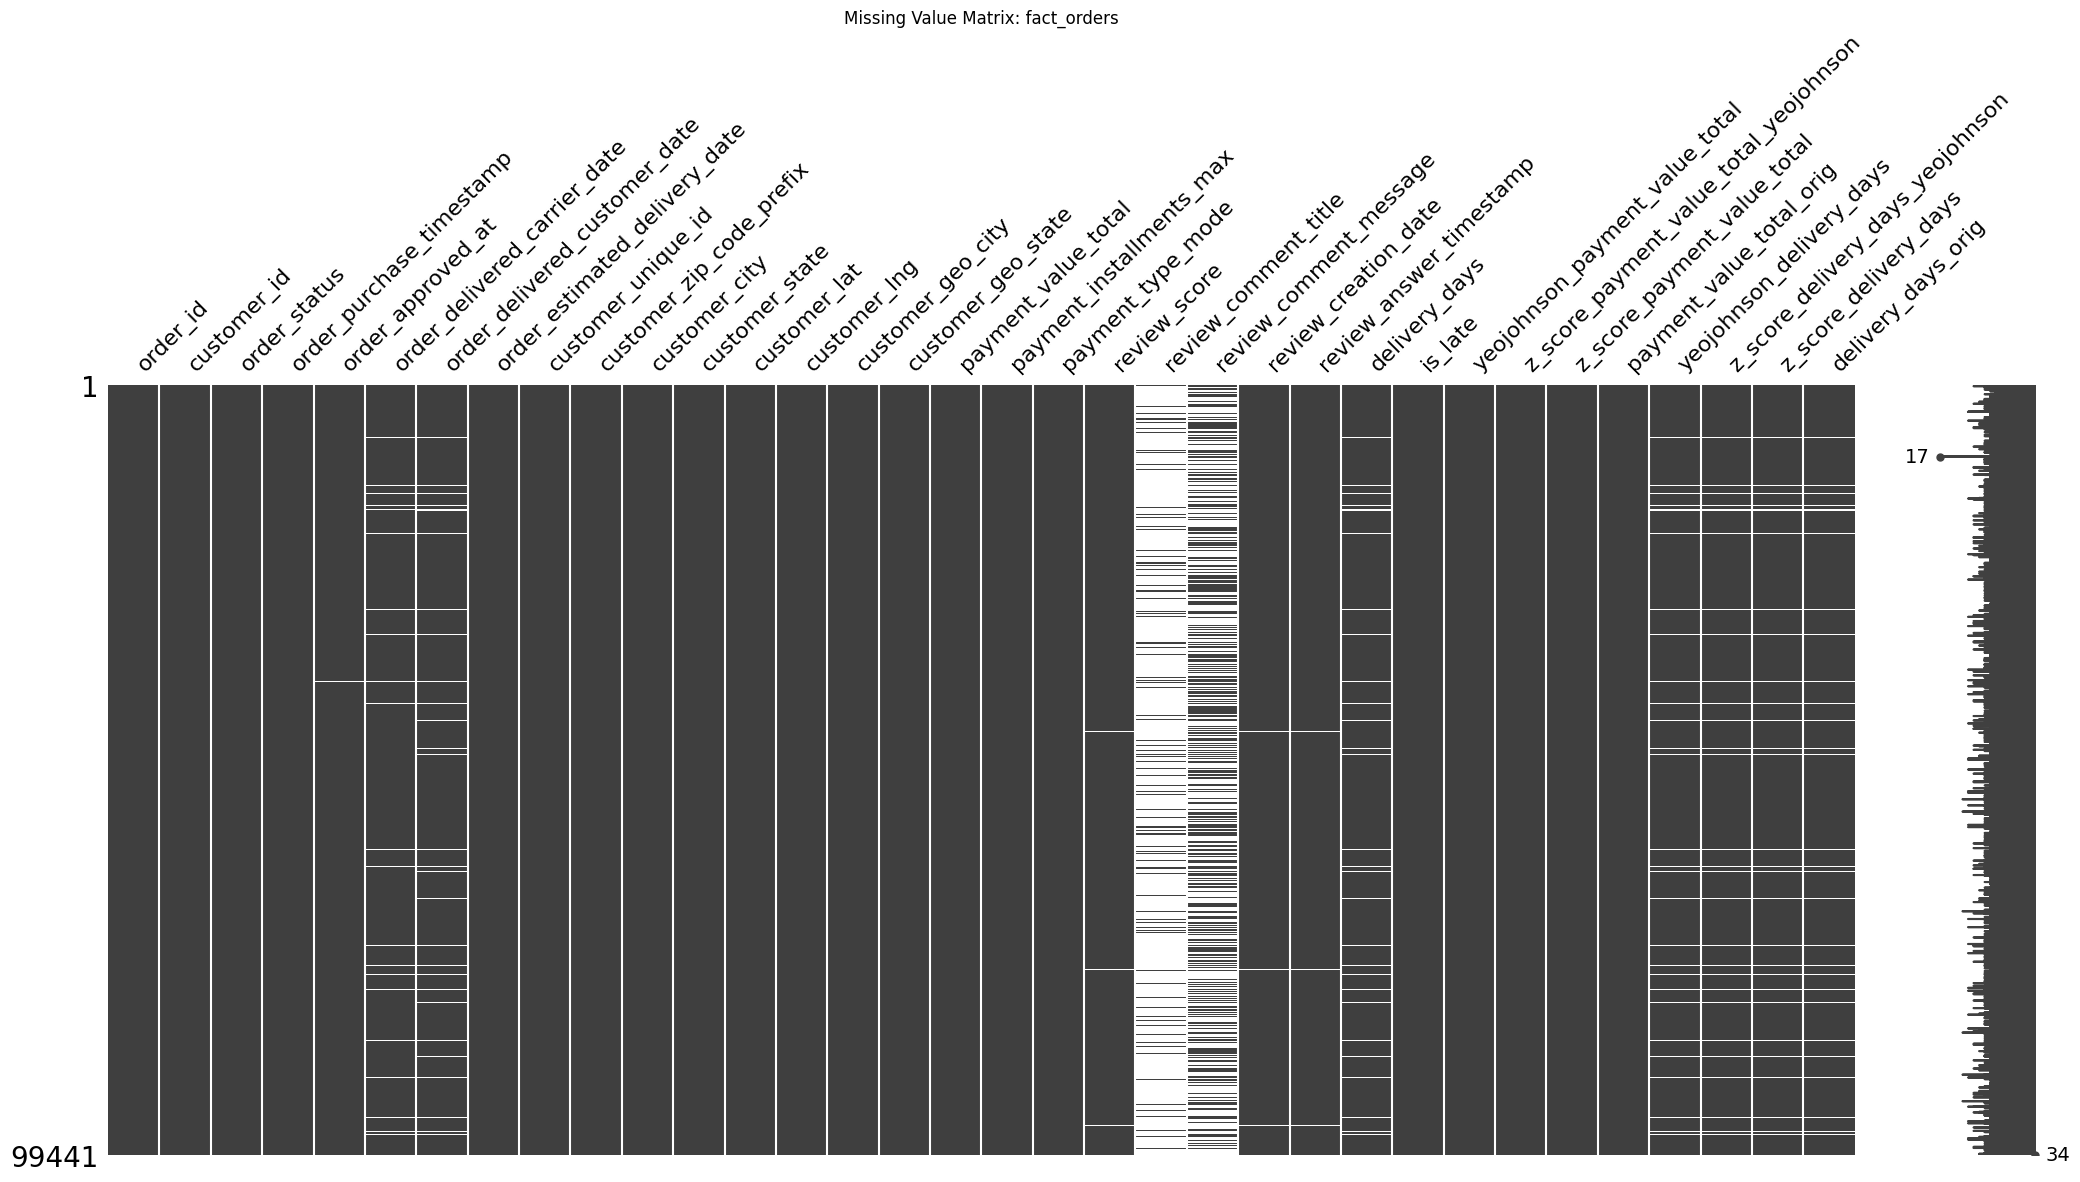

In [48]:
try:

    fact_tables = {
        "fact_orders": fact_orders
    }

    for df_name, df in fact_tables.items():
        print(f"\nMissing value matrix for '{df_name}' dataframe:")
        msno.matrix(df)
        plt.title(f"Missing Value Matrix: {df_name}")
        plt.show()

except ImportError:
    print("The 'missingno' library is not installed. Please install it using: pip install missingno")
    plt.figure(figsize=(12,4))
    sns.heatmap(df.isna().T, cbar=False, cmap="Blues")
    plt.title(f"Mapa simple de faltantes ({df_name} - all columns)")
    plt.ylabel("Variables")
    plt.xlabel("Observaciones")
    plt.show()
except Exception as e:
    print(f"An error occurred while generating the missing value matrix: {e}")
    plt.figure(figsize=(12,4))
    sns.heatmap(df.isna().T, cbar=False, cmap="Blues")
    plt.title(f"Mapa simple de faltantes ({df_name} - all columns)")
    plt.ylabel("Variables")
    plt.xlabel("Observaciones")
    plt.show()

Podemos ver que las columnas de titulo de la review y la review en si tienen muchos valores nulos, y como no vamos a hacer analisis de texto, decidimos eliminarlas.

In [49]:
columns_to_drop = ['review_comment_title', 'review_comment_message']

fact_orders = fact_orders.drop(columns=columns_to_drop)

print("Columns dropped successfully.")
print("Shape of fact_orders after dropping columns:", fact_orders.shape)

Columns dropped successfully.
Shape of fact_orders after dropping columns: (99441, 32)


In [50]:
def littles_mcar_test(df):
    numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
    exclude_cols = ['order_id', 'customer_id', 'review_comment_title', 'review_comment_message',
                    'order_item_id', 'product_id', 'seller_id', 'customer_unique_id',
                    'customer_zip_code_prefix', 'seller_zip_code_prefix']

    use_cols = [col for col in numerical_cols if col not in exclude_cols]

    if not use_cols:
        print("No suitable numerical columns found for MCAR test.")
        return np.nan, 0, np.nan


    X = df[use_cols].copy().replace({pd.NA: np.nan})

    missing_mask = X.isna()

    imp_mean = SimpleImputer(strategy="mean")
    X_imp = pd.DataFrame(imp_mean.fit_transform(X), columns=use_cols, index=X.index)

    patterns = missing_mask.drop_duplicates()
    chi_square = 0.0
    dof = 0

    for _, pattern in patterns.iterrows():
        rows = missing_mask.eq(pattern, axis=1).all(axis=1)
        subset = X.loc[rows]
        if subset.empty:
            continue

        means = X_imp.loc[rows, use_cols].mean()
        diffs = subset[use_cols].fillna(0) - means

        chi_square += (diffs**2).to_numpy().sum()
        dof += diffs.size

    p_value = 1 - chi2.cdf(chi_square, dof) if dof > 0 else np.nan
    return chi_square, dof, p_value

print("Performing Little's MCAR test on fact_orders:")
chi2_stat_orders, dof_orders, p_orders = littles_mcar_test(fact_orders)
print(f"Chi2: {chi2_stat_orders:.2f}")
print(f"Grados de libertad: {dof_orders}")
print(f"p-valor: {p_orders:.4f}")

if np.isnan(p_orders):
    print("Could not calculate p-value for fact_orders (dof=0).")
elif p_orders < 0.05:
    print("Reject H0 (Missingness is NOT MCAR) for fact_orders.")
else:
    print("Fail to reject H0 (Missingness is MCAR) for fact_orders.")

print("\n" + "="*50 + "\n")


Performing Little's MCAR test on fact_orders:
Chi2: 9810921080.21
Grados de libertad: 1491615
p-valor: 0.0000
Reject H0 (Missingness is NOT MCAR) for fact_orders.




In [51]:
# se rechaza que sean MCAR, ahora vamos a ver si hay indicios de MAR
# para eso hacemos regresion

def logit_missing(df, target_col, original_numerical_cols):
    y = df[target_col].isna().astype(int)

    exclude_cols_predictors = [target_col, 'order_id', 'customer_id', 'order_item_id',
                               'product_id', 'seller_id', 'customer_unique_id',
                               'customer_zip_code_prefix', 'seller_zip_code_prefix',
                               'delivery_days', 'delivery_days_real',
                               'delivery_delay_orig']


    use_cols_predictors = [col for col in original_numerical_cols if col != target_col and col not in exclude_cols_predictors]

    if not use_cols_predictors:
        print(f"No suitable original numerical columns found to use as predictors for {target_col}.")
        return None

    X_num = df[use_cols_predictors].apply(pd.to_numeric, errors="coerce").astype(float)

    X = sm.add_constant(X_num, has_constant="add")

    mask = X.notna().all(axis=1) & y.notna()
    X2, y2 = X.loc[mask], y.loc[mask]

    if X2.empty or len(X2.columns) < 2:
         print(f"Not enough valid data or predictors to build a model for {target_col}.")
         return None


    # Logit model fitting
    try:
        X2 = X2.dropna(axis=1)
        if X2.empty:
            print(f"No valid predictor columns remaining after dropping NaNs for {target_col}.")
            return None
        y2 = y.loc[X2.index].astype(int)
        modelo = sm.Logit(y2, X2).fit(disp=0)
        print(f"\n=== Logit missing({target_col}) ===")
        print(modelo.summary())
        return modelo
    except Exception as e:
        print(f"Could not build Logit model for {target_col}: {e}")
        return None


current_numerical_cols_orders = fact_orders.select_dtypes(include=np.number).columns.tolist()
original_numerical_cols_orders = [col for col in current_numerical_cols_orders if not any(keyword in col for keyword in ['boxcox', 'yeojohnson', 'z_score', 'cleaned', '_orig', 'delivery_days', 'delivery_delay', 'delivery_days_real', 'delivery_delay_orig'])]


missing_cols_orders_numerical_original = [col for col in fact_orders.columns[fact_orders.isna().any()].tolist() if col in original_numerical_cols_orders]



print("Analyzing missingness in fact_orders using only original non-date numerical predictors:")
logit_models_orders = {}
for col in missing_cols_orders_numerical_original:
    model = logit_missing(fact_orders, col, original_numerical_cols_orders)
    if model:
        logit_models_orders[col] = model

print("\n" + "="*50 + "\n")


Analyzing missingness in fact_orders using only original non-date numerical predictors:


/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)


Could not build Logit model for customer_lat: Singular matrix


/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packa


=== Logit missing(customer_lng) ===


/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packa

                           Logit Regression Results                           
Dep. Variable:           customer_lng   No. Observations:                98396
Model:                          Logit   Df Residuals:                    98390
Method:                           MLE   Df Model:                            5
Date:                Wed, 12 Nov 2025   Pseudo R-squ.:                     inf
Time:                        21:20:10   Log-Likelihood:            -3.3322e-08
converged:                      False   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                      -22.8700   3.93e+04     -0.001      1.000    -7.7e+04    7.69e+04
customer_lat                 0.0365   1035.344   3.53e-05      1.000   -2029.200    2029.

/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packa


=== Logit missing(payment_value_total) ===


/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packa

                            Logit Regression Results                           
Dep. Variable:     payment_value_total   No. Observations:                98396
Model:                           Logit   Df Residuals:                    98390
Method:                            MLE   Df Model:                            5
Date:                 Wed, 12 Nov 2025   Pseudo R-squ.:                     inf
Time:                         21:20:12   Log-Likelihood:            -1.4645e-10
converged:                       False   LL-Null:                        0.0000
Covariance Type:             nonrobust   LLR p-value:                     1.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                      -12.3563   1.59e+06  -7.79e-06      1.000   -3.11e+06    3.11e+06
customer_lat                -0.3509   3.69e+04  -9.52e-06      1.000   -7.22e+04 

/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



=== Logit missing(payment_installments_max) ===


/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/usr/local/lib/python3.12/dist-packa

                              Logit Regression Results                              
Dep. Variable:     payment_installments_max   No. Observations:                98396
Model:                                Logit   Df Residuals:                    98390
Method:                                 MLE   Df Model:                            5
Date:                      Wed, 12 Nov 2025   Pseudo R-squ.:                     inf
Time:                              21:20:13   Log-Likelihood:            -3.5332e-05
converged:                            False   LL-Null:                        0.0000
Covariance Type:                  nonrobust   LLR p-value:                     1.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 -11.9107   4.08e+05  -2.92e-05      1.000      -8e+05       8e+05
customer_lat           -0.6604    2.3e+04  -2.87e-05    

In [52]:
def interpret_mar_logit_results(model, col_name, alpha=0.05):
    if model is None:
        print("Model was not successfully fitted, cannot interpret results for", col_name)
        return

    print(f"\nInterpretation for missingness in '{col_name}':")

    significant_predictors = []
    for param, p_value in model.pvalues.items():
        if param != 'const' and p_value < alpha:
            significant_predictors.append(param)

    if significant_predictors:
        print(f"Evidence for MAR: Missingness in '{col_name}' is significantly related to the following predictors (p < {alpha}):")
        for predictor in significant_predictors:
            print(f"- {predictor} (p-value: {model.pvalues[predictor]:.4f})")
    else:
        print(f"No significant relationship found between missingness in '{col_name}' and the included numerical predictors (at alpha={alpha}).")
        print("This *could* be an indication of MNAR for this column, but it's not conclusive.")
        print("Missingness might be related to other variables not included or the missing value itself.")

print("Interpreting MAR analysis results for fact_orders:")
for col, model in logit_models_orders.items():
    interpret_mar_logit_results(model, col)
    print("-" * 50)



Interpreting MAR analysis results for fact_orders:

Interpretation for missingness in 'customer_lng':
No significant relationship found between missingness in 'customer_lng' and the included numerical predictors (at alpha=0.05).
This *could* be an indication of MNAR for this column, but it's not conclusive.
Missingness might be related to other variables not included or the missing value itself.
--------------------------------------------------

Interpretation for missingness in 'payment_value_total':
No significant relationship found between missingness in 'payment_value_total' and the included numerical predictors (at alpha=0.05).
This *could* be an indication of MNAR for this column, but it's not conclusive.
Missingness might be related to other variables not included or the missing value itself.
--------------------------------------------------

Interpretation for missingness in 'payment_installments_max':
No significant relationship found between missingness in 'payment_installm

Hicimos la regresión logística sobre las variables numéricas. En la mayoría de los casos,no rechazamos H0 (todos los p valores eran grandes), por lo que no podíamos afirmar que los datos fueran MAR.

Entonces, consideramos que al tratarse de una cantidad menor al 3% de faltantes por columna, aplicamos KNN en todos los casos porque no consideramos que el test fuera tan concluyente ya que la cantidad de datos faltantes era poca.

En conclusión, aplicamos KNN en todos los casos, en las columnas no numéricas de texto imputamos con la moda y en las de fecha y hora rellenamos con NaT, que es un dato nulo pero de tiempo.

In [53]:

numerical_cols_with_missing_orders = fact_orders.select_dtypes(include=np.number).columns[fact_orders.select_dtypes(include=np.number).isna().any()].tolist()
exclude_cols_impute_orders = ['customer_zip_code_prefix']

numerical_cols_to_impute_knn_orders = [col for col in numerical_cols_with_missing_orders if col not in exclude_cols_impute_orders]



print("Applying KNN imputation to numerical columns in fact_orders:")
if numerical_cols_to_impute_knn_orders:
    imputer_orders = KNNImputer(n_neighbors=5)
    fact_orders[numerical_cols_to_impute_knn_orders] = imputer_orders.fit_transform(fact_orders[numerical_cols_to_impute_knn_orders])
    print("KNN imputation applied to:", numerical_cols_to_impute_knn_orders)
else:
    print("No suitable numerical columns found in fact_orders for KNN imputation.")


Applying KNN imputation to numerical columns in fact_orders:
KNN imputation applied to: ['customer_lat', 'customer_lng', 'payment_value_total', 'payment_installments_max', 'review_score', 'delivery_days', 'yeojohnson_payment_value_total', 'z_score_payment_value_total_yeojohnson', 'z_score_payment_value_total', 'payment_value_total_orig', 'yeojohnson_delivery_days', 'z_score_delivery_days_yeojohnson', 'z_score_delivery_days', 'delivery_days_orig']


In [54]:
categorical_cols_to_impute_mode_orders = ['customer_geo_city', 'customer_geo_state', 'payment_type_mode']

print("Applying mode imputation to categorical columns in fact_orders:")
for col in categorical_cols_to_impute_mode_orders:
    if col in fact_orders.columns and fact_orders[col].isna().any():
        mode_value = fact_orders[col].mode()[0]
        fact_orders[col] = fact_orders[col].fillna(mode_value)
        print(f"Mode imputation applied to '{col}' in fact_orders.")
    elif col not in fact_orders.columns:
        print(f"Column '{col}' not found in fact_orders. Skipping mode imputation.")
    else:
         print(f"Column '{col}' in fact_orders has no missing values. Skipping mode imputation.")


Applying mode imputation to categorical columns in fact_orders:
Mode imputation applied to 'customer_geo_city' in fact_orders.
Mode imputation applied to 'customer_geo_state' in fact_orders.
Mode imputation applied to 'payment_type_mode' in fact_orders.


In [55]:
date_cols_to_impute_orders = ['order_delivered_customer_date', 'order_delivered_carrier_date', 'order_approved_at', 'review_creation_date', 'review_answer_timestamp']

print("Applying NaT imputation to date/time columns in fact_orders:")
for col in date_cols_to_impute_orders:
    if col in fact_orders.columns and fact_orders[col].isna().any():
        fact_orders[col] = pd.to_datetime(fact_orders[col], errors='coerce')
        fact_orders[col] = fact_orders[col].fillna(pd.NaT)
        print(f"NaT imputation applied to '{col}' in fact_orders.")
    elif col not in fact_orders.columns:
        print(f"Column '{col}' not found in fact_orders. Skipping NaT imputation.")
    else:
        print(f"Column '{col}' in fact_orders has no missing values. Skipping NaT imputation.")



Applying NaT imputation to date/time columns in fact_orders:
NaT imputation applied to 'order_delivered_customer_date' in fact_orders.
NaT imputation applied to 'order_delivered_carrier_date' in fact_orders.
NaT imputation applied to 'order_approved_at' in fact_orders.
NaT imputation applied to 'review_creation_date' in fact_orders.
NaT imputation applied to 'review_answer_timestamp' in fact_orders.


In [56]:
fact_tables = {
    "fact_orders": fact_orders
}

print("Checking for any remaining missing values in fact tables after imputation:")

all_missing_handled = True
for df_name, df in fact_tables.items():
    n = len(df)
    falt = df.isna().sum()
    falt = falt[falt > 0]

    if not falt.empty:
        all_missing_handled = False
        falt_pct = (falt / n) * 100
        faltantes_df = (
            pd.DataFrame({"Cantidad_faltantes": falt, "Porcentaje": falt_pct})
            .sort_values("Porcentaje", ascending=False)
        )
        faltantes_df["Porcentaje"] = faltantes_df["Porcentaje"].map(lambda x: f"{x:.2f}%")
        print(f"\nRemaining missing values found in '{df_name}' dataframe:")
        display(faltantes_df)
    else:
        print(f"\nNo remaining missing values found in '{df_name}' dataframe.")

if all_missing_handled:
    print("\nAll intended missing values appear to have been handled.")
else:
    print("\nThere are still some missing values that may need further attention.")

Checking for any remaining missing values in fact tables after imputation:

Remaining missing values found in 'fact_orders' dataframe:


,Cantidad_faltantes,Porcentaje
order_delivered_customer_date,2965,2.98%
order_delivered_carrier_date,1783,1.79%
review_creation_date,768,0.77%
review_answer_timestamp,768,0.77%
order_approved_at,160,0.16%



There are still some missing values that may need further attention.


##Análisis exploratorio inicial con visualizaciones.

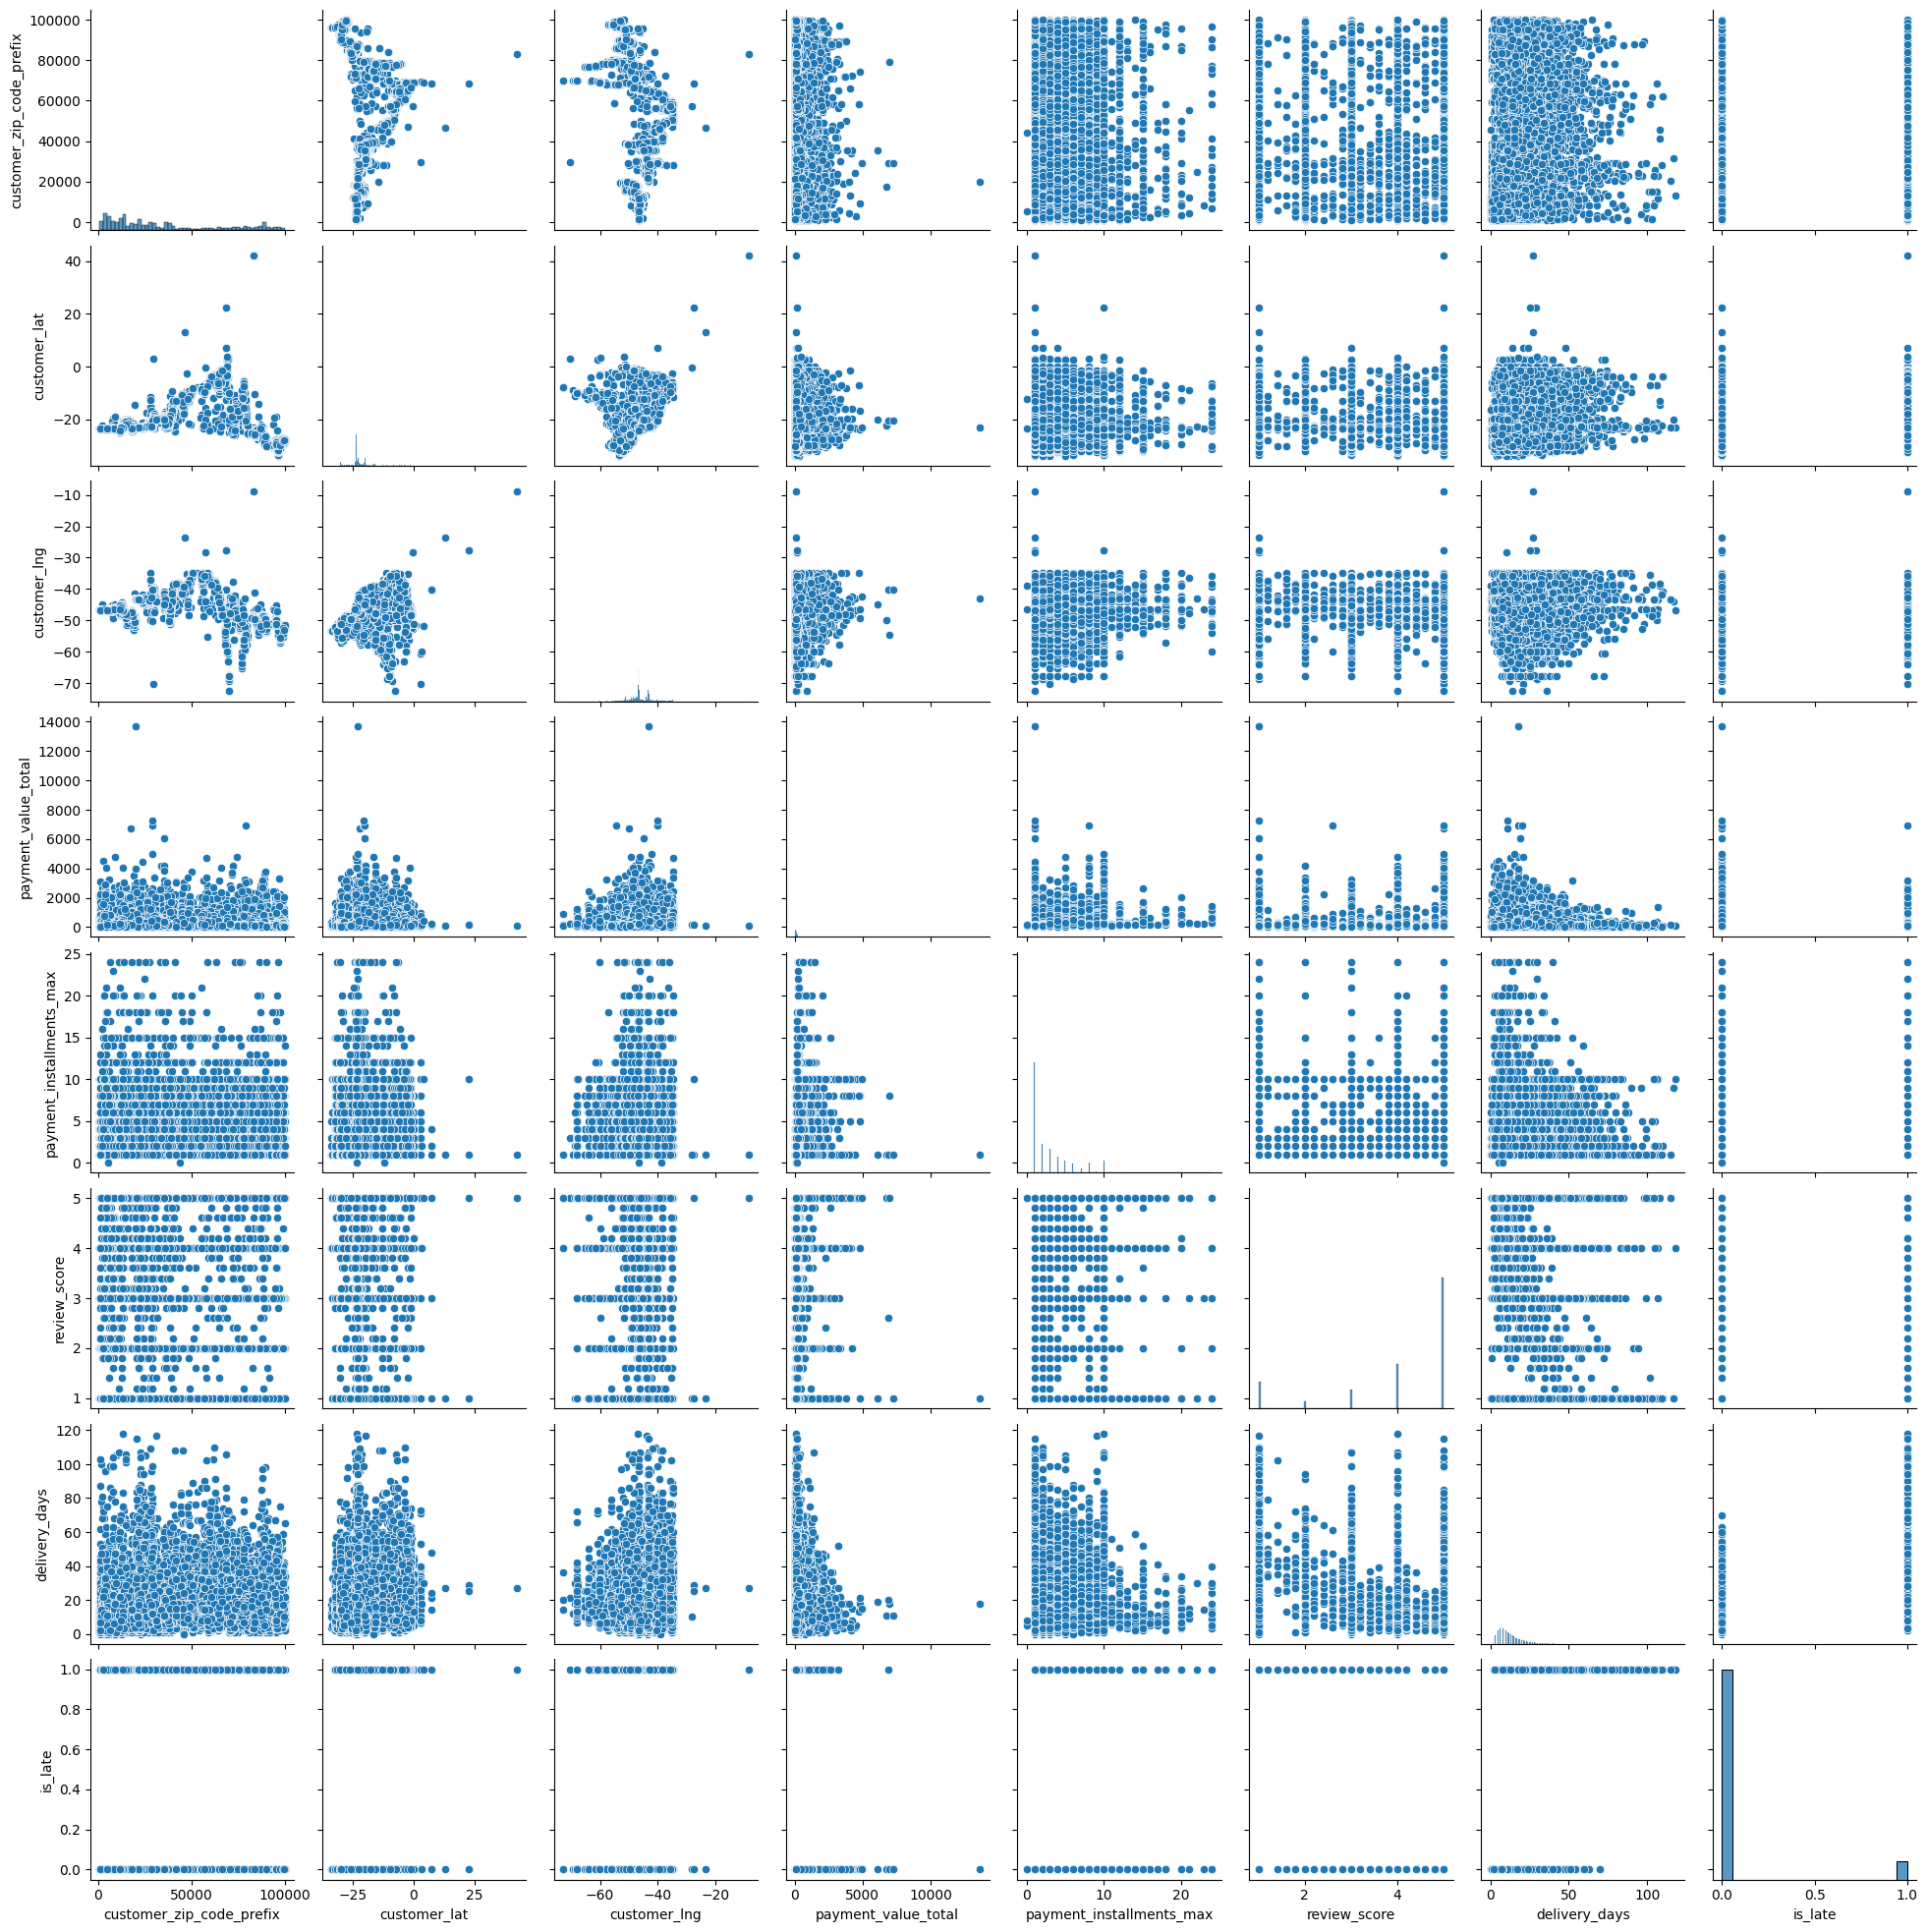

In [57]:
sns.pairplot(fact_orders[cols_numericas_fact_orders])

,customer_zip_code_prefix,customer_lat,customer_lng,payment_value_total,payment_installments_max,review_score,delivery_days,is_late
customer_zip_code_prefix,1.000000,0.125485,-0.304186,0.057796,0.055178,-0.015821,0.282875,0.024429
customer_lat,0.125485,1.000000,0.450093,0.069124,0.063710,-0.041999,0.265116,0.055466
customer_lng,-0.304186,0.450093,1.000000,0.019476,0.040238,-0.052272,0.120332,0.072226
payment_value_total,0.057796,0.069124,0.019476,1.000000,0.319079,-0.048907,0.071595,0.015453
payment_installments_max,0.055178,0.063710,0.040238,0.319079,1.000000,-0.031022,0.052862,0.008560
review_score,-0.015821,-0.041999,-0.052272,-0.048907,-0.031022,1.000000,-0.357467,-0.330311
delivery_days,0.282875,0.265116,0.120332,0.071595,0.052862,-0.357467,1.000000,0.587797
is_late,0.024429,0.055466,0.072226,0.015453,0.008560,-0.330311,0.587797,1.000000


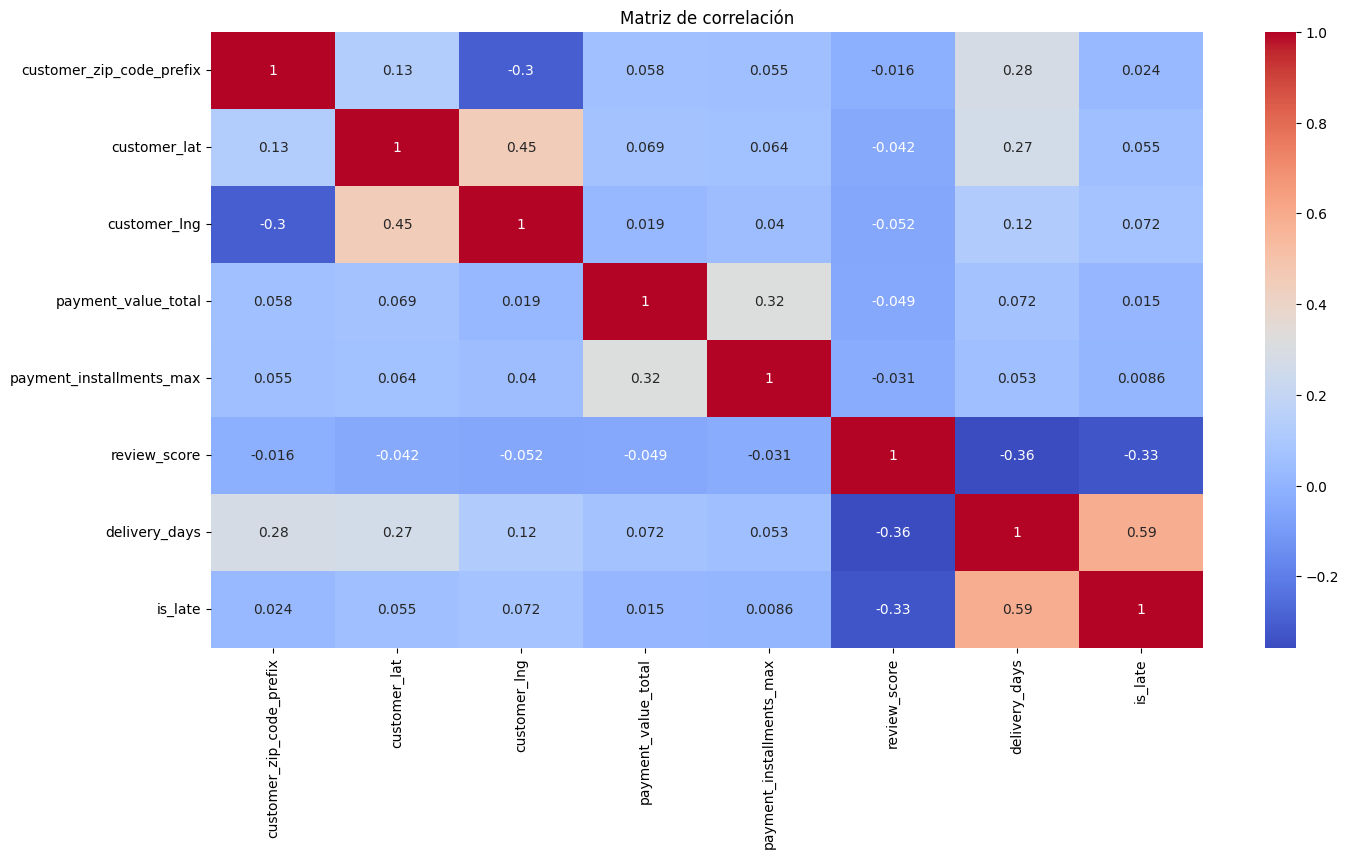

In [58]:
# Filter out z-score and derived columns
cols_to_exclude = ['z_score_payment_value_total_yeojohnson', 'z_score_payment_value_total',
                   'payment_value_total_orig', 'z_score_delivery_days_yeojohnson',
                   'z_score_delivery_days', 'delivery_days_orig', 'yeojohnson_payment_value_total',
                   'yeojohnson_delivery_days']

fact_orders_filtered = fact_orders.drop(columns=cols_to_exclude, errors='ignore')

# calcular correlaciones
corr = fact_orders_filtered.corr(numeric_only=True)
display(corr)

plt.figure(figsize=(16, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Matriz de correlación")
plt.show()

Consideramos que las variables están altamente correlaciones si la correlación es 0.8 o 80%. No se ven variables altamente correlacionadas, entonces no eliminamos.

###Gráficos básicos que permitan contrastar hipótesis de la entrega 1. Conclusiones preliminares.

**Hipótesis 1**: Los clientes pueden agruparse en clusters diferenciados en función de variables como ticket promedio, frecuencia de compra, categorías preferidas y métodos de pago.

**Conclusiones**: Podemos ver que ticket promedio y frecuencia no muestran que haya evidencia para decir que hay clusters separados. La mayoría de los consumidores tiene una frecuencia de compra muy baja (muchas veces por única vez) y la distribución del ticket promedio es asimétrica.

Podemos ver que categoría preferida y método de pago no muestran que haya evidencia para decir que hay clusters separados.

En conclusión, a simple vista no se ve una separación de grupos de clientes que permita realizar clustering, será analizado en profunidad más adelante.

In [59]:
order_total_payment = fact_orders.groupby('order_id')['payment_value_total'].sum().reset_index()
order_total_payment.rename(columns={'payment_value_total': 'order_total_value'}, inplace=True)

fact_orders_with_value = pd.merge(fact_orders, order_total_payment, on='order_id', how='left')

customer_avg_ticket = fact_orders_with_value.groupby('customer_unique_id')['order_total_value'].mean().reset_index()
customer_avg_ticket.rename(columns={'order_total_value': 'avg_ticket_price'}, inplace=True)

customer_purchase_frequency = fact_orders.groupby('customer_unique_id')['order_id'].nunique().reset_index()
customer_purchase_frequency.rename(columns={'order_id': 'purchase_frequency'}, inplace=True)





customer_payment_counts = fact_orders.groupby(['customer_unique_id', 'payment_type_mode']).size().reset_index(name='count')

customer_preferred_payment = customer_payment_counts.loc[customer_payment_counts.groupby('customer_unique_id')['count'].idxmax()].reset_index(drop=True)
customer_preferred_payment.rename(columns={'payment_type_mode': 'preferred_payment_type'}, inplace=True)

customer_metrics = pd.merge(customer_avg_ticket, customer_purchase_frequency, on='customer_unique_id', how='left')
customer_metrics = pd.merge(customer_metrics, customer_preferred_payment[['customer_unique_id', 'preferred_payment_type']], on='customer_unique_id', how='left')


print("Customer-level metrics calculated:")
display(customer_metrics.head())

Customer-level metrics calculated:


,customer_unique_id,avg_ticket_price,purchase_frequency,preferred_payment_type
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90,1,credit_card
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19,1,credit_card
2,0000f46a3911fa3c0805444483337064,86.22,1,credit_card
3,0000f6ccb0745a6a4b88665a16c9f078,43.62,1,credit_card
4,0004aac84e0df4da2b147fca70cf8255,196.89,1,credit_card


Visualizing the distribution of Average Ticket Price:


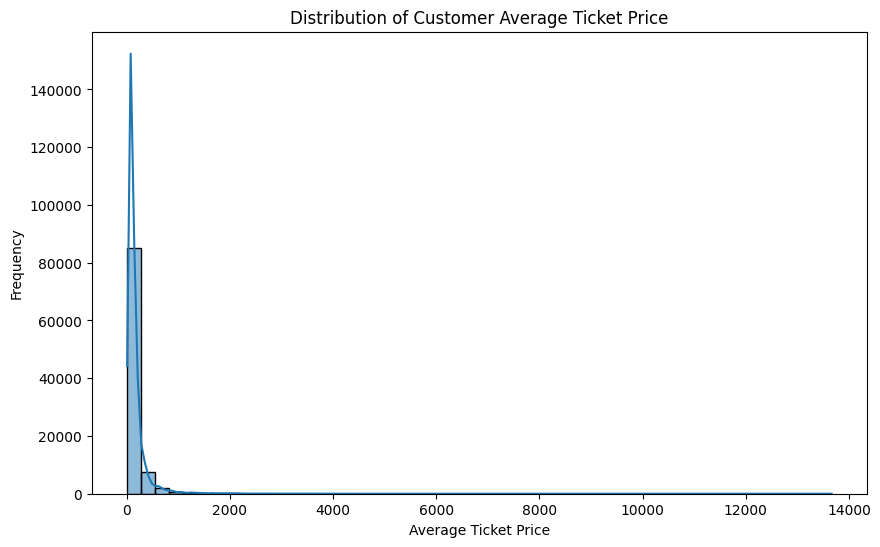


Visualizing the distribution of Purchase Frequency:


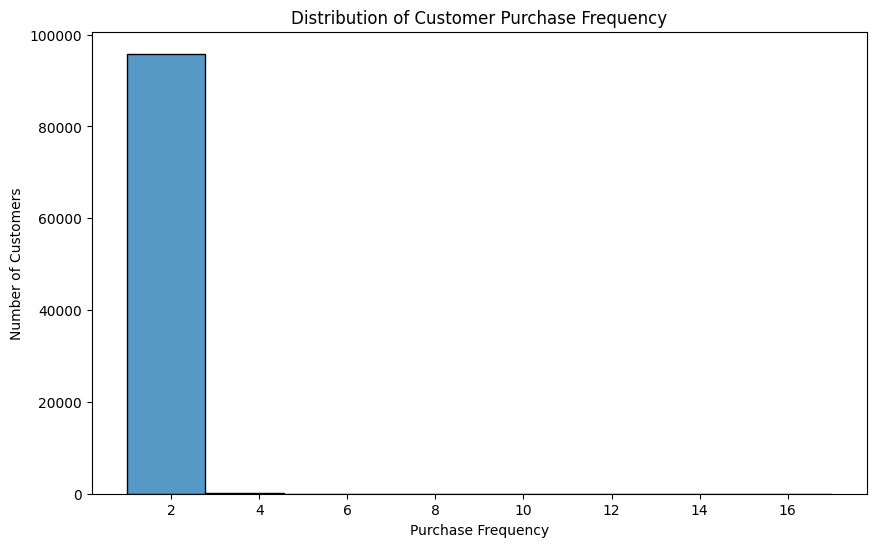

In [60]:
print("Visualizing the distribution of Average Ticket Price:")
plt.figure(figsize=(10, 6))
sns.histplot(customer_metrics['avg_ticket_price'], bins=50, kde=True)
plt.title('Distribution of Customer Average Ticket Price')
plt.xlabel('Average Ticket Price')
plt.ylabel('Frequency')
plt.show()

print("\nVisualizing the distribution of Purchase Frequency:")
plt.figure(figsize=(10, 6))
sns.histplot(customer_metrics['purchase_frequency'], bins=customer_metrics['purchase_frequency'].nunique(), kde=False) # Use unique values as bins for frequency
plt.title('Distribution of Customer Purchase Frequency')
plt.xlabel('Purchase Frequency')
plt.ylabel('Number of Customers')
plt.show()

Exploring relationship between Average Ticket Price and Purchase Frequency:


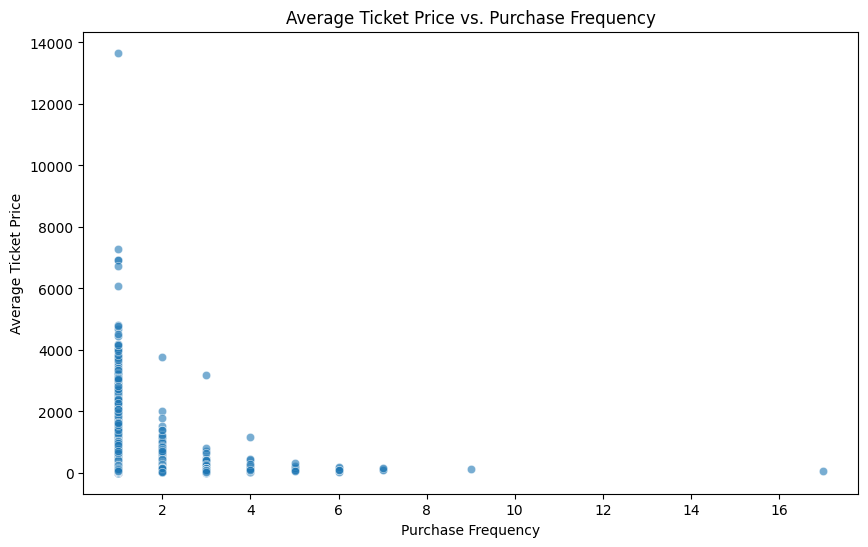


Exploring relationship between Preferred Payment Type and Average Ticket Price:


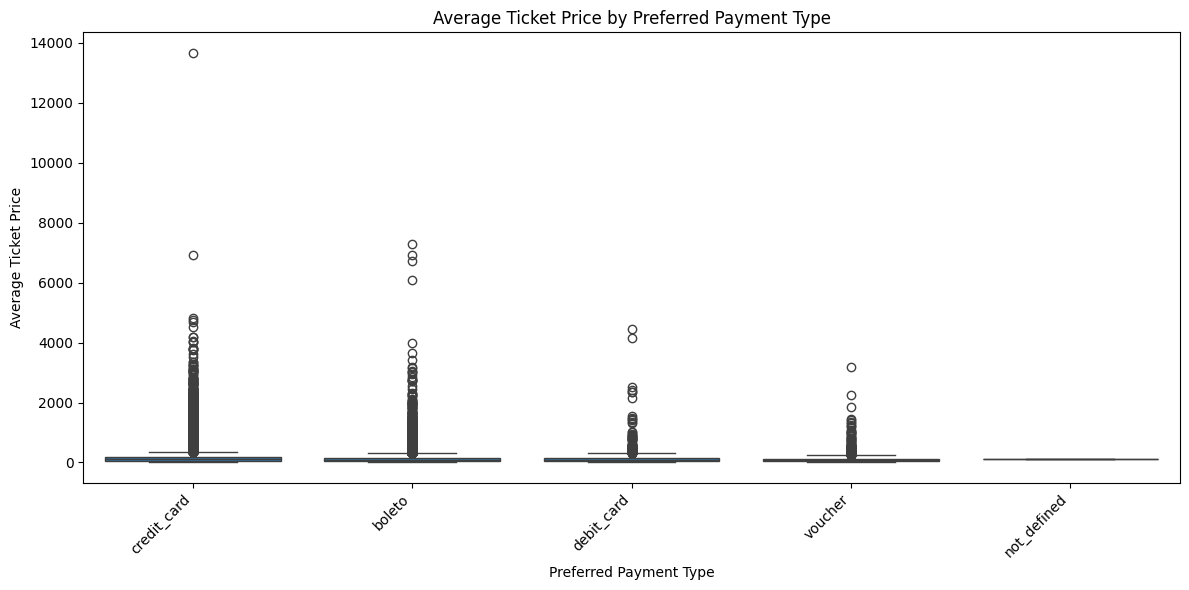

In [61]:
print("Exploring relationship between Average Ticket Price and Purchase Frequency:")
plt.figure(figsize=(10, 6))
sns.scatterplot(data=customer_metrics, x='purchase_frequency', y='avg_ticket_price', alpha=0.6)
plt.title('Average Ticket Price vs. Purchase Frequency')
plt.xlabel('Purchase Frequency')
plt.ylabel('Average Ticket Price')
plt.show()

print("\nExploring relationship between Preferred Payment Type and Average Ticket Price:")
plt.figure(figsize=(12, 6))
sns.boxplot(data=customer_metrics, x='preferred_payment_type', y='avg_ticket_price')
plt.title('Average Ticket Price by Preferred Payment Type')
plt.xlabel('Preferred Payment Type')
plt.ylabel('Average Ticket Price')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


**Hipótesis 2**: Los distintos clusters de clientes muestran comportamientos de compra y niveles de fidelidad diferentes, lo cual permite diseñar estrategias de marketing personalizadas (por ejemplo retención para clientes frecuentes, descuentos para clientes esporádicos).

**Conclusiones**: Podemos ver que hay diferencias notables entre el ticket promedio mediano de consumidores que compraron una única vez y consumidores recurrentes.

Podemos ver que los compradores recurrentes tienden a preferir ciertos tipos de pago más que los compradores únicos.

Podemos ver que los compradores recurrentes están más concentrados en ciertas categorías de productos en comparación con los compradores únicos.

En resumen, las métricas de comportamiento de compra (ticket promedio, categoría/método de pago preferido) difieren según un nivel de fidelidad simple (frecuencia de compra). Si bien estos gráficos no prueban definitivamente la hipótesis para todos los posibles clusters, demuestran que existen diferencias de comportamiento entre al menos dos grupos de clientes definidos por su frecuencia de compra.

Comparing Average Ticket Price by Loyalty Level:


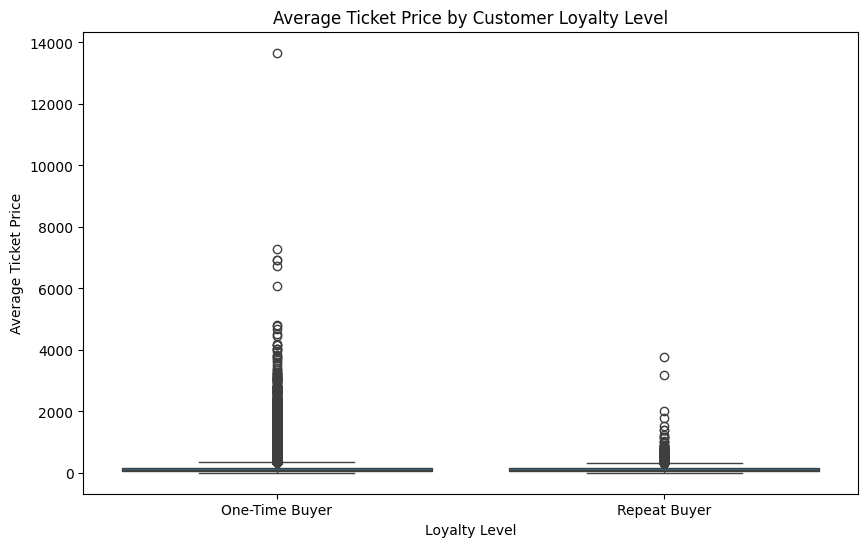


Comparing Preferred Payment Type by Loyalty Level:


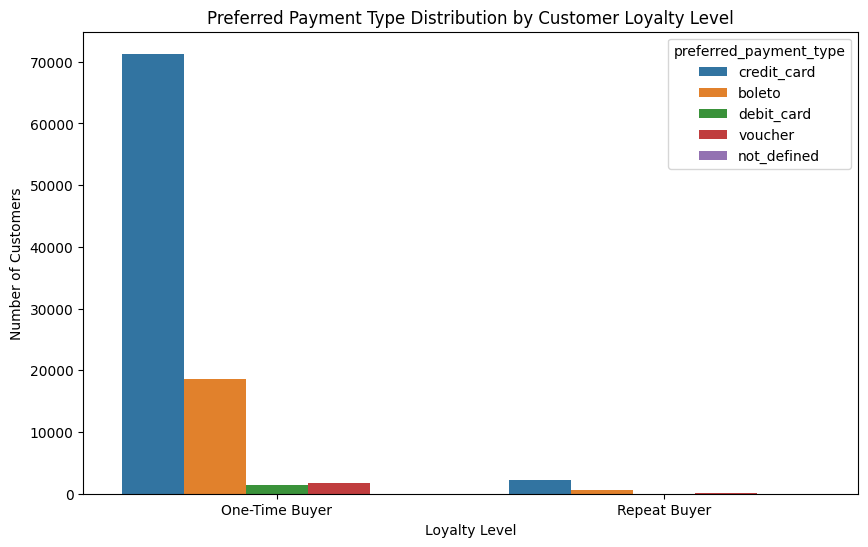

In [62]:
customer_metrics['loyalty_level'] = customer_metrics['purchase_frequency'].apply(lambda x: 'Repeat Buyer' if x > 1 else 'One-Time Buyer')

print("Comparing Average Ticket Price by Loyalty Level:")
plt.figure(figsize=(10, 6))
sns.boxplot(data=customer_metrics, x='loyalty_level', y='avg_ticket_price')
plt.title('Average Ticket Price by Customer Loyalty Level')
plt.xlabel('Loyalty Level')
plt.ylabel('Average Ticket Price')
plt.show()

print("\nComparing Preferred Payment Type by Loyalty Level:")
plt.figure(figsize=(10, 6))
sns.countplot(data=customer_metrics, x='loyalty_level', hue='preferred_payment_type')
plt.title('Preferred Payment Type Distribution by Customer Loyalty Level')
plt.xlabel('Loyalty Level')
plt.ylabel('Number of Customers')
plt.show()

**Hipótesis 3**: A mayor demora de entrega, mayor probabilidad reviews <= 3 (impacto en satisfacción).

**Conclusiones**: Al observar este gráfico de caja, vemos la distribución de la demora de entrega para los pedidos que recibieron una puntuación de reseña baja (<= 3) en comparación con los que recibieron una puntuación de reseña alta (> 3).

Podemos concluir que parece haber una relación entre la demora de entrega y la satisfacción del cliente. La demora en satisfacción alta es menor en promedio que la de satisfacción baja.

In [63]:
# Demora (puede ser negativa si llegó antes de la fecha estimada)
fact_orders["delivery_delay"] = (
    fact_orders["order_delivered_customer_date"] - fact_orders["order_estimated_delivery_date"]
).dt.days

Visualizing the relationship between Delivery Delay and Satisfaction Level:


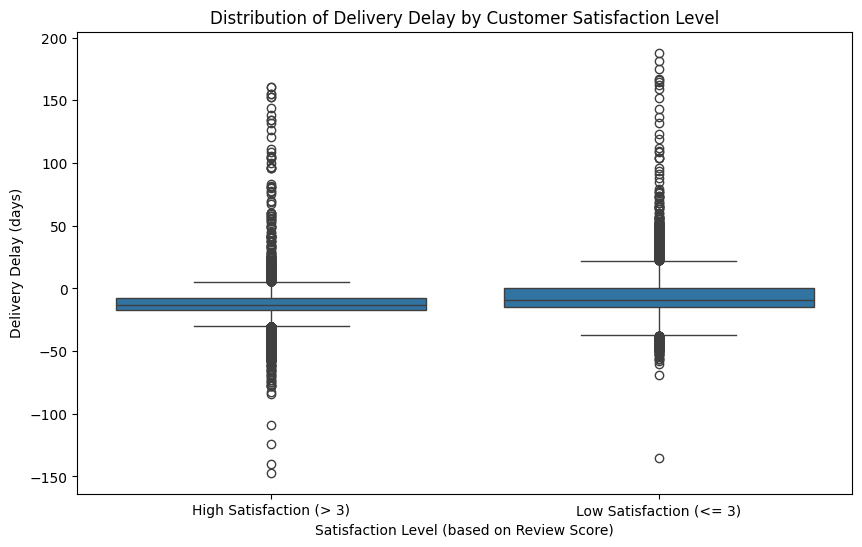

In [64]:
if 'review_score' in fact_orders.columns:
    fact_orders_for_hypothesis_3 = fact_orders.dropna(subset=['review_score']).copy()
    fact_orders_for_hypothesis_3['satisfaction_level'] = fact_orders_for_hypothesis_3['review_score'].apply(lambda score: 'Low Satisfaction (<= 3)' if score <= 3 else 'High Satisfaction (> 3)')

    print("Visualizing the relationship between Delivery Delay and Satisfaction Level:")
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=fact_orders_for_hypothesis_3, x='satisfaction_level', y='delivery_delay')
    plt.title('Distribution of Delivery Delay by Customer Satisfaction Level')
    plt.xlabel('Satisfaction Level (based on Review Score)')
    plt.ylabel('Delivery Delay (days)')
    plt.show()


else:
    print("The 'review_score' column is not available in fact_orders to test Hypothesis 3.")

#Preprocesamiento para machine learning


## Correlacion

,customer_zip_code_prefix,customer_lat,customer_lng,payment_value_total,payment_installments_max,review_score,delivery_days,is_late,delivery_delay
customer_zip_code_prefix,1.000000,0.125485,-0.304186,0.057796,0.055178,-0.015821,0.282875,0.024429,-0.072757
customer_lat,0.125485,1.000000,0.450093,0.069124,0.063710,-0.041999,0.265116,0.055466,-0.011330
customer_lng,-0.304186,0.450093,1.000000,0.019476,0.040238,-0.052272,0.120332,0.072226,0.050849
payment_value_total,0.057796,0.069124,0.019476,1.000000,0.319079,-0.048907,0.071595,0.015453,-0.017721
payment_installments_max,0.055178,0.063710,0.040238,0.319079,1.000000,-0.031022,0.052862,0.008560,-0.030930
review_score,-0.015821,-0.041999,-0.052272,-0.048907,-0.031022,1.000000,-0.357467,-0.330311,-0.270454
delivery_days,0.282875,0.265116,0.120332,0.071595,0.052862,-0.357467,1.000000,0.587797,0.535873
is_late,0.024429,0.055466,0.072226,0.015453,0.008560,-0.330311,0.587797,1.000000,0.605266
delivery_delay,-0.072757,-0.011330,0.050849,-0.017721,-0.030930,-0.270454,0.535873,0.605266,1.000000


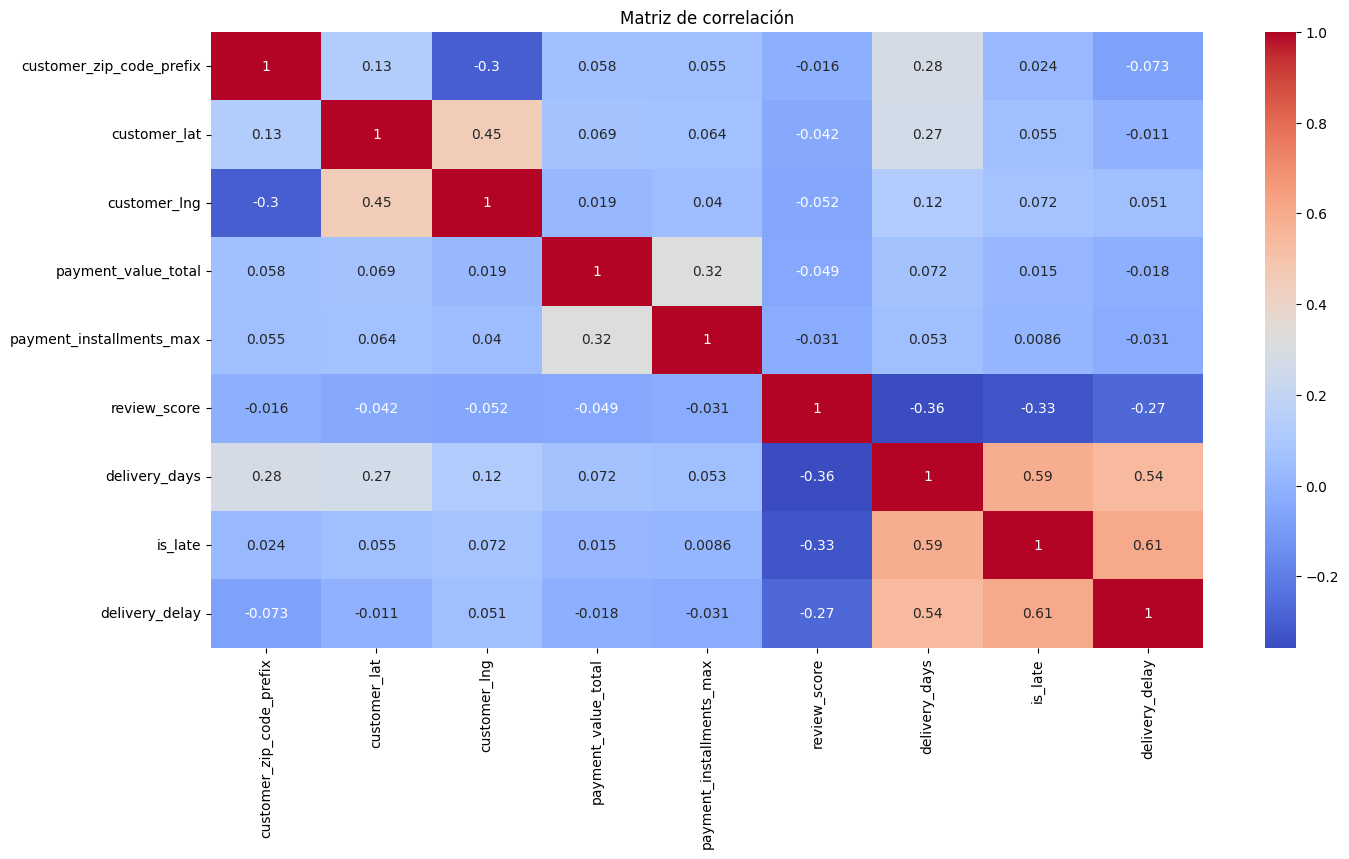

In [65]:
# Filter out z-score and derived columns
cols_to_exclude = ['z_score_payment_value_total_yeojohnson', 'z_score_payment_value_total',
                   'payment_value_total_orig', 'z_score_delivery_days_yeojohnson',
                   'z_score_delivery_days', 'delivery_days_orig', 'yeojohnson_payment_value_total',
                   'yeojohnson_delivery_days']

fact_orders_filtered = fact_orders.drop(columns=cols_to_exclude, errors='ignore')

# calcular correlaciones
corr = fact_orders_filtered.corr(numeric_only=True)
display(corr)

plt.figure(figsize=(16, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Matriz de correlación")
plt.show()

No hay variables altamente correlacionadas es por eso que decidimos mantener todas.

## Encoding de variables categóricas con justificación


In [66]:
categorical_cols = fact_orders.select_dtypes(include=['object', 'category']).columns.tolist()
print("Categorical variables in fact_orders:")
print(categorical_cols)

Categorical variables in fact_orders:
['order_id', 'customer_id', 'order_status', 'customer_unique_id', 'customer_city', 'customer_state', 'customer_geo_city', 'customer_geo_state', 'payment_type_mode']


In [67]:
fact_orders['order_status'].unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

In [68]:
fact_orders['customer_city'].nunique()

4119

In [69]:
fact_orders['customer_geo_city'].nunique()

4055

In [70]:
fact_orders['customer_geo_state'].nunique()

27

In [71]:
fact_orders['payment_type_mode'].nunique()

5

In [72]:
fact_orders['payment_type_mode'].unique()

array(['voucher', 'boleto', 'credit_card', 'debit_card', 'not_defined'],
      dtype=object)

De las variables categoricas vamos a analizar solamente las que tengan menos de 15 categorias. En este caso, serian 'order_status' y 'payment_type_mode'.

### One hot encoder

In [73]:
# Create a new DataFrame with relevant columns for modeling
numerical_cols_for_modeling = fact_orders.select_dtypes(include=np.number).columns.tolist()
categorical_cols_for_modeling = ['payment_type_mode', 'order_status']

# Exclude unnecessary columns from numerical_cols_for_modeling
exclude_from_modeling = [
    'customer_zip_code_prefix',
    'yeojohnson_payment_value_total', 'z_score_payment_value_total_yeojohnson',
    'z_score_payment_value_total', 'payment_value_total_orig',
    'yeojohnson_delivery_days', 'z_score_delivery_days_yeojohnson',
    'z_score_delivery_days', 'delivery_days_orig'
]

numerical_cols_for_modeling = [col for col in numerical_cols_for_modeling if col not in exclude_from_modeling]


fact_orders_model = fact_orders[categorical_cols_for_modeling + numerical_cols_for_modeling].copy()

print("DataFrame for modeling created with shape:", fact_orders_model.shape)
display(fact_orders_model.head())

DataFrame for modeling created with shape: (99441, 10)


,payment_type_mode,order_status,customer_lat,customer_lng,payment_value_total,payment_installments_max,review_score,delivery_days,is_late,delivery_delay
0,voucher,delivered,-23.576983,-46.587161,38.71,1.0,4.0,8.0,0,-8.0
1,boleto,delivered,-12.177924,-44.660711,141.46,1.0,4.0,13.0,0,-6.0
2,credit_card,delivered,-16.745150,-48.514783,179.12,3.0,5.0,9.0,0,-18.0
3,credit_card,delivered,-5.774190,-35.271143,72.20,1.0,5.0,13.0,0,-13.0
4,credit_card,delivered,-23.676370,-46.514627,28.62,1.0,5.0,2.0,0,-10.0


In [74]:
from sklearn.preprocessing import OneHotEncoder

# Apply OneHotEncoder to categorical columns
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False) # Use sparse_output=False for dense output
onehot_encoded_cols = encoder.fit_transform(fact_orders_model[categorical_cols_for_modeling])

# Create a DataFrame from the one-hot encoded columns
onehot_df = pd.DataFrame(onehot_encoded_cols, columns=encoder.get_feature_names_out(categorical_cols_for_modeling), index=fact_orders_model.index)

# Drop original categorical columns and concatenate the one-hot encoded DataFrame
fact_orders_model_encoded = fact_orders_model.drop(columns=categorical_cols_for_modeling)
fact_orders_model_encoded = pd.concat([fact_orders_model_encoded, onehot_df], axis=1)

print("One-hot encoding applied. Shape of encoded DataFrame:", fact_orders_model_encoded.shape)
display(fact_orders_model_encoded.head())

One-hot encoding applied. Shape of encoded DataFrame: (99441, 21)


,customer_lat,customer_lng,payment_value_total,payment_installments_max,review_score,delivery_days,is_late,delivery_delay,payment_type_mode_boleto,payment_type_mode_credit_card,payment_type_mode_debit_card,payment_type_mode_not_defined,payment_type_mode_voucher,order_status_approved,order_status_canceled,order_status_created,order_status_delivered,order_status_invoiced,order_status_processing,order_status_shipped,order_status_unavailable
0,-23.576983,-46.587161,38.71,1.0,4.0,8.0,0,-8.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,-12.177924,-44.660711,141.46,1.0,4.0,13.0,0,-6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,-16.745150,-48.514783,179.12,3.0,5.0,9.0,0,-18.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,-5.774190,-35.271143,72.20,1.0,5.0,13.0,0,-13.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,-23.676370,-46.514627,28.62,1.0,5.0,2.0,0,-10.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## Estandarización

In [75]:
from sklearn.preprocessing import StandardScaler

# Identify numerical columns after one-hot encoding
numerical_cols_after_encoding = fact_orders_model_encoded.select_dtypes(include=np.number).columns.tolist()

# Apply StandardScaler to numerical columns
scaler = StandardScaler()
scaled_numerical_data = scaler.fit_transform(fact_orders_model_encoded[numerical_cols_after_encoding])

# Create a DataFrame from the scaled data
scaled_numerical_df = pd.DataFrame(scaled_numerical_data, columns=numerical_cols_after_encoding, index=fact_orders_model_encoded.index)

# Replace original numerical columns with scaled ones
for col in numerical_cols_after_encoding:
    fact_orders_model_encoded[col] = scaled_numerical_df[col]

print("Standardization applied. Final shape of preprocessed DataFrame:", fact_orders_model_encoded.shape)
display(fact_orders_model_encoded.head())

Standardization applied. Final shape of preprocessed DataFrame: (99441, 21)


,customer_lat,customer_lng,payment_value_total,payment_installments_max,review_score,delivery_days,is_late,delivery_delay,payment_type_mode_boleto,payment_type_mode_credit_card,payment_type_mode_debit_card,payment_type_mode_not_defined,payment_type_mode_voucher,order_status_approved,order_status_canceled,order_status_created,order_status_delivered,order_status_invoiced,order_status_processing,order_status_shipped,order_status_unavailable
0,-0.425984,-0.101638,-0.550960,-0.71088,-0.061051,-0.462136,-0.292292,0.380691,-0.498362,-1.807315,-0.124881,-0.005493,6.990716,-0.004485,-0.079529,-0.007091,0.175247,-0.056282,-0.055101,-0.106102,-0.078498
1,1.608554,0.373821,-0.088013,-0.71088,-0.061051,0.094309,-0.292292,0.577081,2.006573,-1.807315,-0.124881,-0.005493,-0.143047,-0.004485,-0.079529,-0.007091,0.175247,-0.056282,-0.055101,-0.106102,-0.078498
2,0.793382,-0.577386,0.081666,0.02559,0.681687,-0.350847,-0.292292,-0.601261,-0.498362,0.553307,-0.124881,-0.005493,-0.143047,-0.004485,-0.079529,-0.007091,0.175247,-0.056282,-0.055101,-0.106102,-0.078498
3,2.751511,2.691220,-0.400069,-0.71088,0.681687,0.094309,-0.292292,-0.110285,-0.498362,0.553307,-0.124881,-0.005493,-0.143047,-0.004485,-0.079529,-0.007091,0.175247,-0.056282,-0.055101,-0.106102,-0.078498
4,-0.443723,-0.083736,-0.596421,-0.71088,0.681687,-1.129871,-0.292292,0.184301,-0.498362,0.553307,-0.124881,-0.005493,-0.143047,-0.004485,-0.079529,-0.007091,0.175247,-0.056282,-0.055101,-0.106102,-0.078498


## PCA

In [76]:
from sklearn.decomposition import PCA
import numpy as np

pca = PCA()

# Apply PCA to the standardized and encoded DataFrame
# Assuming fact_orders_model_encoded is your preprocessed DataFrame
X_scaled = fact_orders_model_encoded.copy()

# Drop date columns which contain NaT values
date_cols_in_model = X_scaled.select_dtypes(include=['datetime64[ns]']).columns.tolist()
X_scaled = X_scaled.drop(columns=date_cols_in_model)

# Impute missing values in delivery_delay
if 'delivery_delay' in X_scaled.columns:
    # Using median imputation as it's robust to outliers
    median_delay = X_scaled['delivery_delay'].median()
    X_scaled['delivery_delay'].fillna(median_delay, inplace=True)
    print(f"Imputed missing values in 'delivery_delay' with the median ({median_delay:.2f}).")
else:
    print("'delivery_delay' column not found in X_scaled.")


# Check for any remaining missing values
print("Missing values in X_scaled before PCA:")
print(X_scaled.isnull().sum()[X_scaled.isnull().sum() > 0])


# Fit PCA
pca.fit(X_scaled)

# Explained variance and cumulative variance
explained_var = pca.explained_variance_ratio_
cum_var = np.cumsum(explained_var)

# Create a DataFrame to display the results
pca_results = pd.DataFrame({
    'Componente': [f'PC{i+1}' for i in range(len(explained_var))],
    'Varianza_Individual': explained_var,
    'Varianza_Acumulada': cum_var
})

display(pca_results)

Imputed missing values in 'delivery_delay' with the median (-0.01).
Missing values in X_scaled before PCA:
Series([], dtype: int64)


/tmp/ipython-input-726888057.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_scaled['delivery_delay'].fillna(median_delay, inplace=True)


,Componente,Varianza_Individual,Varianza_Acumulada
0,PC1,1.188290e-01,0.118829
1,PC2,1.062554e-01,0.225084
2,PC3,9.656188e-02,0.321646
3,PC4,6.804726e-02,0.389694
4,PC5,5.494274e-02,0.444636
5,PC6,5.212623e-02,0.496762
6,PC7,4.914414e-02,0.545907
7,PC8,4.836975e-02,0.594276
8,PC9,4.791339e-02,0.642190
9,PC10,4.779697e-02,0.689987


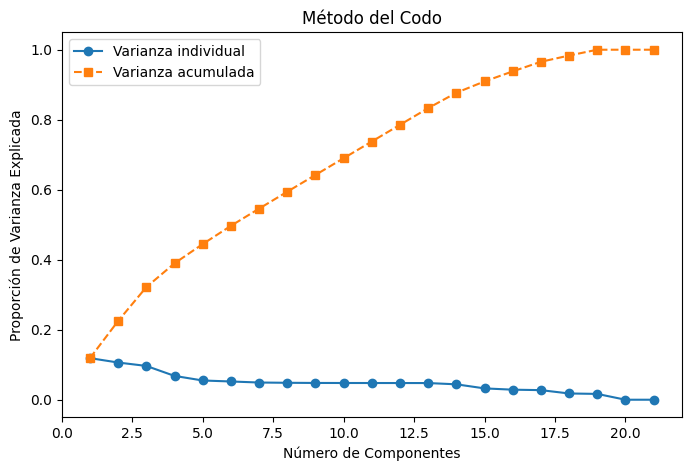

In [77]:
plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained_var)+1), explained_var, 'o-', label='Varianza individual')
plt.plot(range(1, len(cum_var)+1), cum_var, 's--', label='Varianza acumulada')
plt.xlabel('Número de Componentes')
plt.ylabel('Proporción de Varianza Explicada')
plt.title('Método del Codo')
plt.legend()
plt.show()

In [78]:
# Autovalores (eigenvalues) del PCA en los datos escalados
# En scikit-learn, explained_variance_ ya representa los autovalores de la matriz de covarianza de los datos escalados
eigenvalues_scaled = pca.explained_variance_

print("Autovalores de los datos escalados (comparables al criterio de Kaiser > 1):")
for i, eigenvalue in enumerate(eigenvalues_scaled):
    print(f"Componente PC{i+1}: {eigenvalue:.4f}") # Criterio de Kaiser (Autovalor > 1) - Aplicado correctamente a los autovalores de los datos escalados
print("\nAutovalores mayores a 1 (Aplicando Criterio de Kaiser a autovalores de datos escalados):")
components_kaiser = [i + 1 for i, eigenvalue in enumerate(eigenvalues_scaled) if eigenvalue > 1]

if components_kaiser:
    for comp in components_kaiser:
        print(f"Componente PC{comp}: {eigenvalues_scaled[comp-1]:.4f}")
else:
    print("Ningún autovalor es mayor a 1 según el criterio de Kaiser.")

# El número de componentes a retener según Kaiser sería la longitud de la lista components_kaiser.
print(f"\nNúmero de componentes a retener según el Criterio de Kaiser: {len(components_kaiser)}")

Autovalores de los datos escalados (comparables al criterio de Kaiser > 1):
Componente PC1: 2.4919
Componente PC2: 2.2282
Componente PC3: 2.0249
Componente PC4: 1.4270
Componente PC5: 1.1522
Componente PC6: 1.0931
Componente PC7: 1.0306
Componente PC8: 1.0143
Componente PC9: 1.0048
Componente PC10: 1.0023
Componente PC11: 1.0011
Componente PC12: 1.0000
Componente PC13: 0.9986
Componente PC14: 0.9229
Componente PC15: 0.6793
Componente PC16: 0.6017
Componente PC17: 0.5744
Componente PC18: 0.3747
Componente PC19: 0.3486
Componente PC20: 0.0000
Componente PC21: 0.0000

Autovalores mayores a 1 (Aplicando Criterio de Kaiser a autovalores de datos escalados):
Componente PC1: 2.4919
Componente PC2: 2.2282
Componente PC3: 2.0249
Componente PC4: 1.4270
Componente PC5: 1.1522
Componente PC6: 1.0931
Componente PC7: 1.0306
Componente PC8: 1.0143
Componente PC9: 1.0048
Componente PC10: 1.0023
Componente PC11: 1.0011
Componente PC12: 1.0000

Número de componentes a retener según el Criterio de Kaiser

# Clustering

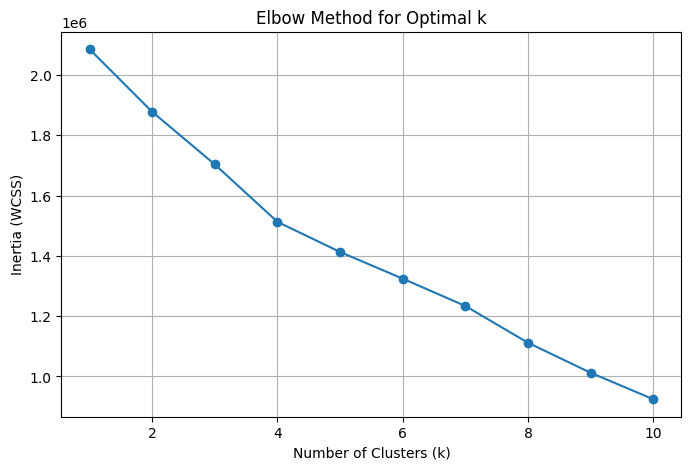

In [79]:
from sklearn.cluster import KMeans

# Initialize the K-means model
inertia = []
k_range = range(1, 11)  # Test from 1 to 10 clusters


for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=300, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)  # WCSS


# Plot the elbow graph
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()


No se observa un codo definido.

In [80]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
k_range = range(2, 11) # Silhouette score requiere al menos 2 clusters


for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=300, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)


# Plot the silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for Optimal k')
plt.grid(True)
plt.show()


# Find the optimal k based on silhouette score
optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]
max_silhouette_score = np.max(silhouette_scores)




KeyboardInterrupt: 

No se pueden sacar conclusiones claras

In [ ]:

from sklearn.metrics import calinski_harabasz_score


# Range of K to evaluate
k_values = range(2, 11)
vrc_scores = []


for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42) # Usar n_init=10 para consistencia
    labels = kmeans.fit_predict(X_scaled)
    score = calinski_harabasz_score(X_scaled, labels)
    vrc_scores.append(score)


# Plot VRC
plt.figure(figsize=(8, 5))
plt.plot(k_values, vrc_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('VRC (Calinski-Harabasz Score)')
plt.title('VRC vs Number of Clusters')
plt.grid(True)
plt.show()


# Find the optimal k based on VRC score
optimal_k_vrc = k_values[np.argmax(vrc_scores)]
max_vrc_score = np.max(vrc_scores)


print(f"El pico del índice VRC se encuentra en {optimal_k_vrc} clusters, con un valor de {max_vrc_score:.2f}.")

En este caso, tampoco se llega a conclusiones claras

In [82]:
# inicializar y ajustar el modelo de kmeans
kmeans = KMeans(
    n_clusters=10,
    n_init=10,
    max_iter=300,
    random_state=42
)


kmeans.fit(X_scaled)

df_clustered = fact_orders_model_encoded.copy()
df_clustered['cluster'] = kmeans.labels_


print("Primeras filas del DataFrame con etiquetas de cluster:")
display(df_clustered.head())


print("Conteo de elementos por cluster:")
print(df_clustered["cluster"].value_counts())


Primeras filas del DataFrame con etiquetas de cluster:


,customer_lat,customer_lng,payment_value_total,payment_installments_max,review_score,delivery_days,is_late,delivery_delay,payment_type_mode_boleto,payment_type_mode_credit_card,payment_type_mode_debit_card,payment_type_mode_not_defined,payment_type_mode_voucher,order_status_approved,order_status_canceled,order_status_created,order_status_delivered,order_status_invoiced,order_status_processing,order_status_shipped,order_status_unavailable,cluster
0,-0.425984,-0.101638,-0.550960,-0.71088,-0.061051,-0.462136,-0.292292,0.380691,-0.498362,-1.807315,-0.124881,-0.005493,6.990716,-0.004485,-0.079529,-0.007091,0.175247,-0.056282,-0.055101,-0.106102,-0.078498,4
1,1.608554,0.373821,-0.088013,-0.71088,-0.061051,0.094309,-0.292292,0.577081,2.006573,-1.807315,-0.124881,-0.005493,-0.143047,-0.004485,-0.079529,-0.007091,0.175247,-0.056282,-0.055101,-0.106102,-0.078498,2
2,0.793382,-0.577386,0.081666,0.02559,0.681687,-0.350847,-0.292292,-0.601261,-0.498362,0.553307,-0.124881,-0.005493,-0.143047,-0.004485,-0.079529,-0.007091,0.175247,-0.056282,-0.055101,-0.106102,-0.078498,4
3,2.751511,2.691220,-0.400069,-0.71088,0.681687,0.094309,-0.292292,-0.110285,-0.498362,0.553307,-0.124881,-0.005493,-0.143047,-0.004485,-0.079529,-0.007091,0.175247,-0.056282,-0.055101,-0.106102,-0.078498,4
4,-0.443723,-0.083736,-0.596421,-0.71088,0.681687,-1.129871,-0.292292,0.184301,-0.498362,0.553307,-0.124881,-0.005493,-0.143047,-0.004485,-0.079529,-0.007091,0.175247,-0.056282,-0.055101,-0.106102,-0.078498,4


Conteo de elementos por cluster:
cluster
4    71150
2    17609
0     7719
3     1107
1      625
6      609
8      314
5      301
7        5
9        2
Name: count, dtype: int64


In [83]:
pca_final = PCA(n_components=12, random_state=42)
X_pca = pca_final.fit_transform(X_scaled)


print("Shape of X_pca:", X_pca.shape)
print("First 5 rows of X_pca:\n", X_pca[:5])

Shape of X_pca: (99441, 12)
First 5 rows of X_pca:
 [[-2.18346827e-01 -2.21638343e+00 -3.27412184e-01  1.05017818e-01
  -1.87598718e+00  3.79675118e+00  1.39419346e+00  4.28407139e+00
  -4.40653247e-01  5.76443232e-02 -1.49985452e+00  1.59338779e-01]
 [ 5.64730856e-01 -2.45755253e+00  3.72803680e-01  1.61632293e+00
   5.46142665e-01 -3.01753112e-01 -5.59350551e-01 -1.75664445e-01
   1.00338650e-02  9.37409191e-02  1.93886770e-02 -6.85820024e-04]
 [-9.31808982e-01  6.99160740e-01  1.08865859e-02  3.08613629e-01
  -6.45671079e-02 -4.78813690e-02 -1.01510043e-01 -2.61109272e-02
   1.18062497e-02  1.97549884e-02  9.51512184e-03 -1.83735574e-03]
 [ 2.46294843e-01  7.21579977e-01  6.32584813e-01  3.49200682e+00
  -1.45039959e+00 -2.75176308e-01 -4.41251633e-01 -1.21728794e-01
   2.05722160e-01  3.97406108e-01  1.67390794e-01  1.25945266e-02]
 [-1.17906327e+00  1.70299008e-01 -3.34983417e-02 -4.99461063e-01
  -9.72298820e-01 -1.99424400e-01 -2.01825106e-01 -6.39659034e-02
   1.77668225e-02  9

In [84]:
# inicializar y ajustar el modelo de kmeans con 3 clusters
kmeans = KMeans(
    n_clusters=2,        # Usamos 3 clusters como se indicó
    n_init=10,           # Número de inicializaciones para encontrar los mejores centroides
    max_iter=300,        # Máximo de iteraciones por inicialización
    random_state=42      # Semilla para reproducibilidad
)


# Ajustar K-Means a los componentes principales de PCA (X_pca)
kmeans.fit(X_pca)


# Agregamos las etiquetas de cluster al DataFrame original para su análisis
# Crear una copia para evitar SettingWithCopyWarning
df_clustered_pca = fact_orders_model_encoded.copy()
df_clustered_pca['cluster_pca'] = kmeans.labels_


print("K-Means clustering aplicado a los componentes PCA.")
print("Primeras filas del DataFrame con etiquetas de cluster de PCA:")
display(df_clustered_pca.head())


K-Means clustering aplicado a los componentes PCA.
Primeras filas del DataFrame con etiquetas de cluster de PCA:


,customer_lat,customer_lng,payment_value_total,payment_installments_max,review_score,delivery_days,is_late,delivery_delay,payment_type_mode_boleto,payment_type_mode_credit_card,payment_type_mode_debit_card,payment_type_mode_not_defined,payment_type_mode_voucher,order_status_approved,order_status_canceled,order_status_created,order_status_delivered,order_status_invoiced,order_status_processing,order_status_shipped,order_status_unavailable,cluster_pca
0,-0.425984,-0.101638,-0.550960,-0.71088,-0.061051,-0.462136,-0.292292,0.380691,-0.498362,-1.807315,-0.124881,-0.005493,6.990716,-0.004485,-0.079529,-0.007091,0.175247,-0.056282,-0.055101,-0.106102,-0.078498,0
1,1.608554,0.373821,-0.088013,-0.71088,-0.061051,0.094309,-0.292292,0.577081,2.006573,-1.807315,-0.124881,-0.005493,-0.143047,-0.004485,-0.079529,-0.007091,0.175247,-0.056282,-0.055101,-0.106102,-0.078498,0
2,0.793382,-0.577386,0.081666,0.02559,0.681687,-0.350847,-0.292292,-0.601261,-0.498362,0.553307,-0.124881,-0.005493,-0.143047,-0.004485,-0.079529,-0.007091,0.175247,-0.056282,-0.055101,-0.106102,-0.078498,1
3,2.751511,2.691220,-0.400069,-0.71088,0.681687,0.094309,-0.292292,-0.110285,-0.498362,0.553307,-0.124881,-0.005493,-0.143047,-0.004485,-0.079529,-0.007091,0.175247,-0.056282,-0.055101,-0.106102,-0.078498,1
4,-0.443723,-0.083736,-0.596421,-0.71088,0.681687,-1.129871,-0.292292,0.184301,-0.498362,0.553307,-0.124881,-0.005493,-0.143047,-0.004485,-0.079529,-0.007091,0.175247,-0.056282,-0.055101,-0.106102,-0.078498,1


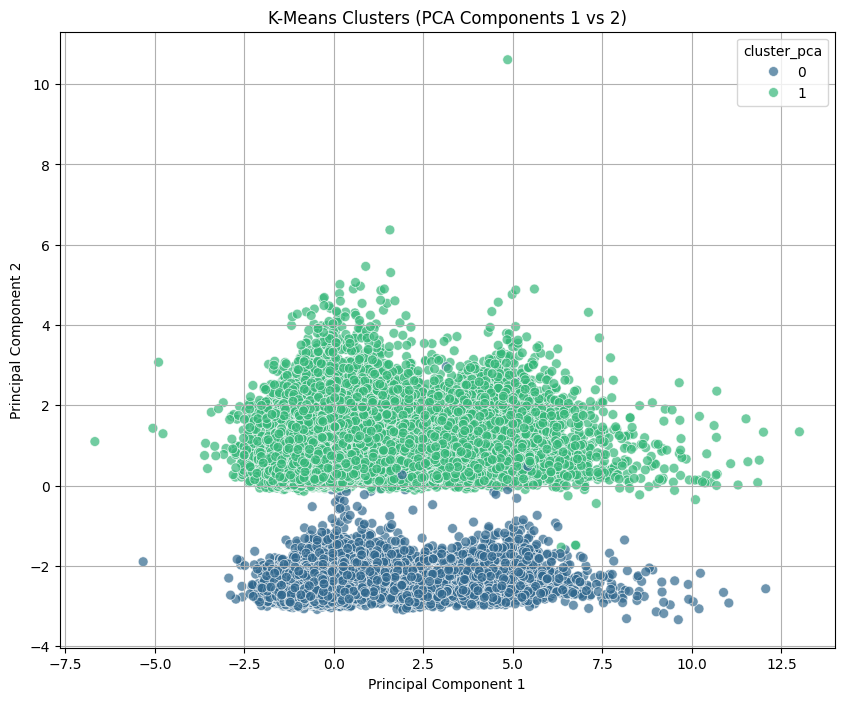

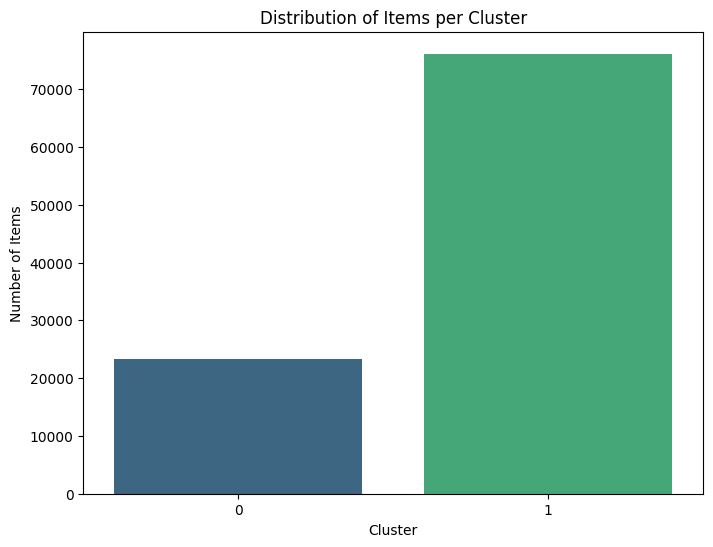

Visualización de clusters completada. Gráfico de dispersión de los dos primeros componentes PCA con etiquetas de cluster y gráfico de barras de la distribución de clusters mostrados.


In [85]:
# Visualización de los clusters en los dos primeros componentes principales
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df_clustered_pca['cluster_pca'], palette='viridis', legend='full', s=50, alpha=0.7)
plt.title('K-Means Clusters (PCA Components 1 vs 2)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


# Visualización de la distribución de ítems por cluster
plt.figure(figsize=(8, 6))
sns.countplot(x='cluster_pca', data=df_clustered_pca, hue='cluster_pca', palette='viridis', legend=False) # Se agregó hue y legend=False para evitar el FutureWarning
plt.title('Distribution of Items per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Items')
plt.show()


print("Visualización de clusters completada. Gráfico de dispersión de los dos primeros componentes PCA con etiquetas de cluster y gráfico de barras de la distribución de clusters mostrados.")


Aca podemos observar que no hay una clara distincion.

In [86]:
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


# Aplicación de DBSCAN
dbscan = DBSCAN(eps=1.25, min_samples=5)  # Ajustar los parámetros según el conjunto de datos
clusters = dbscan.fit_predict(X_scaled)



In [87]:
# Añadimos los resultados de clustering al DataFrame original
fact_orders_model_encoded['cluster2'] = clusters

In [88]:
# Calculate RFM metrics at the customer level
# Define a reference date as the maximum purchase date in the dataset plus one day
reference_date = fact_orders['order_purchase_timestamp'].max() + pd.Timedelta(days=1)


# Aggregate fact_order_items to get customer-level data for RFM
customer_rfm = fact_orders.groupby('customer_id').agg(
    RFM_Recency=('order_purchase_timestamp', lambda date: (reference_date - date.max()).days),
    RFM_Frequency=('order_id', 'nunique'),
    RFM_Monetary=('payment_value_total', 'sum')
).reset_index()


# --- Adapt the original code for the new customer_rfm DataFrame ---


# Monetary is already calculated as 'RFM_Monetary'


# Frequency is already calculated as 'RFM_Frequency'


# Recency is already calculated as 'RFM_Recency'


# Web engagement is not directly available in fact_order_items, so we'll omit it.


# Inspection of the new variables
print("Customer RFM DataFrame created.")
display(customer_rfm[["RFM_Monetary", "RFM_Frequency", "RFM_Recency"]].describe().T)


# Outliers extremos en Monetary (percentil 99)
if "RFM_Monetary" in customer_rfm.columns:
    p99_monetary = customer_rfm["RFM_Monetary"].quantile(0.99)
    ratio_outliers = (customer_rfm["RFM_Monetary"] > p99_monetary).mean() * 100
    print(f"Percentil 99 de 'RFM_Monetary': {p99_monetary:.2f}")
    print(f"Clientes por encima del p99: {ratio_outliers:.2f}%")


Customer RFM DataFrame created.


,count,mean,std,min,25%,50%,75%,max
RFM_Monetary,99441.0,160.994357,221.948777,9.59,62.01,105.29,176.97,13664.08
RFM_Frequency,99441.0,1.000000,0.000000,1.00,1.00,1.00,1.00,1.00
RFM_Recency,99441.0,290.900192,153.667316,1.00,167.00,272.00,401.00,773.00


Percentil 99 de 'RFM_Monetary': 1075.79
Clientes por encima del p99: 1.00%


In [89]:
from sklearn.preprocessing import StandardScaler


# Seleccionar las columnas RFM para el clustering
rfm_features = ['RFM_Recency', 'RFM_Frequency', 'RFM_Monetary']
X_rfm = customer_rfm[rfm_features]


# Escalar los datos RFM
scaler_rfm = StandardScaler()
X_rfm_scaled = scaler_rfm.fit_transform(X_rfm)


# Convertir el array escalado de nuevo a un DataFrame para facilitar la visualización y análisis
X_rfm_scaled_df = pd.DataFrame(X_rfm_scaled, columns=rfm_features, index=customer_rfm.index)


print("RFM data scaled successfully.")
display(X_rfm_scaled_df.head())




RFM data scaled successfully.


,RFM_Recency,RFM_Frequency,RFM_Monetary
0,0.306507,0.0,-0.208402
1,1.093926,0.0,-0.421651
2,1.991974,0.0,0.155107
3,0.892190,0.0,0.082703
4,-0.598049,0.0,-0.243230


Resultados PCA para RFM:
Componente 1: 50.05% de varianza explicada
Componente 2: 49.95% de varianza explicada
Componente 3: 0.00% de varianza explicada
Varianza total explicada por los 2 primeros componentes: 100.00%


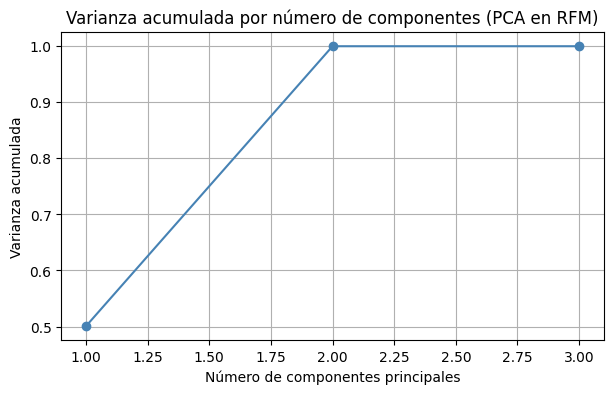

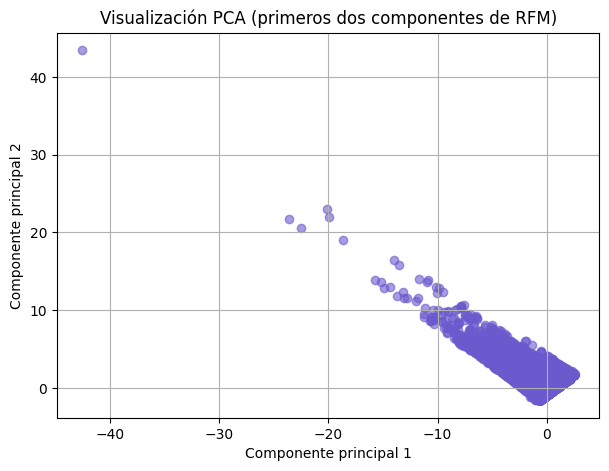

In [90]:


from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np


# Usamos las variables RFM escaladas directamente
# X_rfm_scaled_df ya es un DataFrame con las columnas correctas y escaladas


# Aplicamos PCA
# n_components debe ser igual o menor al número de características (3 para RFM)
pca_rfm = PCA(n_components=3)
pca_result_rfm = pca_rfm.fit_transform(X_rfm_scaled_df)


# Varianza explicada
explained_variance_rfm = pca_rfm.explained_variance_ratio_
cumulative_variance_rfm = np.cumsum(explained_variance_rfm)


# Mostramos resultados
print("Resultados PCA para RFM:")
for i, v in enumerate(explained_variance_rfm):
    print(f"Componente {i+1}: {v*100:.2f}% de varianza explicada")
print(f"Varianza total explicada por los 2 primeros componentes: {cumulative_variance_rfm[1]*100:.2f}%")


# Gráfico de varianza acumulada
plt.figure(figsize=(7,4))
plt.plot(range(1, len(cumulative_variance_rfm)+1), cumulative_variance_rfm, marker='o', color='steelblue')
plt.title("Varianza acumulada por número de componentes (PCA en RFM)")
plt.xlabel("Número de componentes principales")
plt.ylabel("Varianza acumulada")
plt.grid(True)
plt.show()


# Gráfico de dispersión (2 componentes principales)
plt.figure(figsize=(7,5))
plt.scatter(pca_result_rfm[:, 0], pca_result_rfm[:, 1], alpha=0.6, color='slateblue')
plt.title("Visualización PCA (primeros dos componentes de RFM)")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.grid(True)
plt.show()


In [91]:


from sklearn.metrics import silhouette_score, calinski_harabasz_score


silhouette_scores_rfm = []
vrc_scores_rfm = []
k_range_metrics = range(2, 11) # Se necesita al menos 2 clusters para estas métricas


for k in k_range_metrics:
    kmeans_rfm = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels_rfm = kmeans_rfm.fit_predict(pca_result_rfm)


    # Calcular Silhouette Score
    score_silhouette = silhouette_score(pca_result_rfm, labels_rfm)
    silhouette_scores_rfm.append(score_silhouette)


    # Calcular Calinski-Harabasz Score (VRC)
    score_vrc = calinski_harabasz_score(pca_result_rfm, labels_rfm)
    vrc_scores_rfm.append(score_vrc)


# Plot Silhouette Scores
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range_metrics, silhouette_scores_rfm, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score para k óptimo en RFM (usando PCA)')
plt.grid(True)


# Plot VRC Scores
plt.subplot(1, 2, 2)
plt.plot(k_range_metrics, vrc_scores_rfm, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('VRC (Calinski-Harabasz Score)')
plt.title('VRC para k óptimo en RFM (usando PCA)')
plt.grid(True)
plt.tight_layout()
plt.show()


# Encontrar el k óptimo basado en Silhouette y VRC
optimal_k_silhouette_rfm = k_range_metrics[np.argmax(silhouette_scores_rfm)]
max_silhouette_score_rfm = np.max(silhouette_scores_rfm)


optimal_k_vrc_rfm = k_range_metrics[np.argmax(vrc_scores_rfm)]
max_vrc_score_rfm = np.max(vrc_scores_rfm)


print(f"El valor máximo del coeficiente de silueta para RFM es {max_silhouette_score_rfm:.2f} en {optimal_k_silhouette_rfm} clusters.")
print(f"El pico del índice VRC para RFM se encuentra en {optimal_k_vrc_rfm} clusters, con un valor de {max_vrc_score_rfm:.2f}.")




KeyboardInterrupt: 

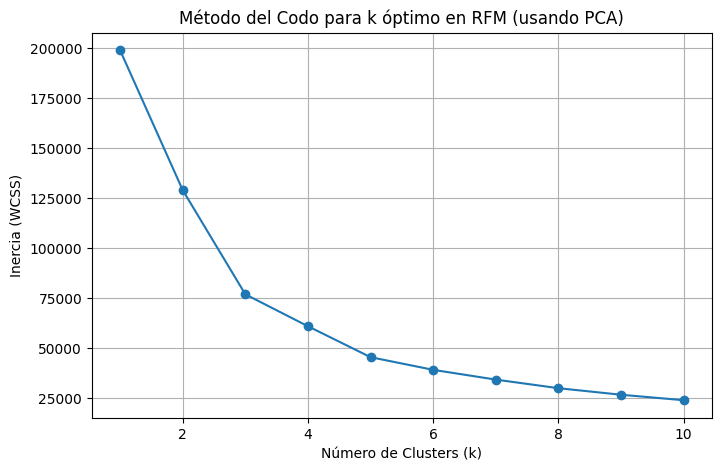

Observa el gráfico para identificar el 'codo' que sugiere el número óptimo de clusters.


In [92]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns


# El resultado del PCA en RFM ya está en 'pca_result_rfm'


# Método del Codo para determinar el número óptimo de clusters (k)
inertia_rfm = []
k_range_rfm = range(1, 11)


for k in k_range_rfm:
    kmeans_rfm = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans_rfm.fit(pca_result_rfm)
    inertia_rfm.append(kmeans_rfm.inertia_)


plt.figure(figsize=(8, 5))
plt.plot(k_range_rfm, inertia_rfm, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia (WCSS)')
plt.title('Método del Codo para k óptimo en RFM (usando PCA)')
plt.grid(True)
plt.show()


print("Observa el gráfico para identificar el 'codo' que sugiere el número óptimo de clusters.")


K-Means clustering aplicado con 2 clusters a los datos RFM (PCA-transformados).
Primeras filas del DataFrame de clientes con etiquetas de cluster:


,customer_id,RFM_Recency,RFM_Frequency,RFM_Monetary,RFM_Cluster
0,00012a2ce6f8dcda20d059ce98491703,338,1,114.74,0
1,000161a058600d5901f007fab4c27140,459,1,67.41,0
2,0001fd6190edaaf884bcaf3d49edf079,597,1,195.42,0
3,0002414f95344307404f0ace7a26f1d5,428,1,179.35,0
4,000379cdec625522490c315e70c7a9fb,199,1,107.01,1


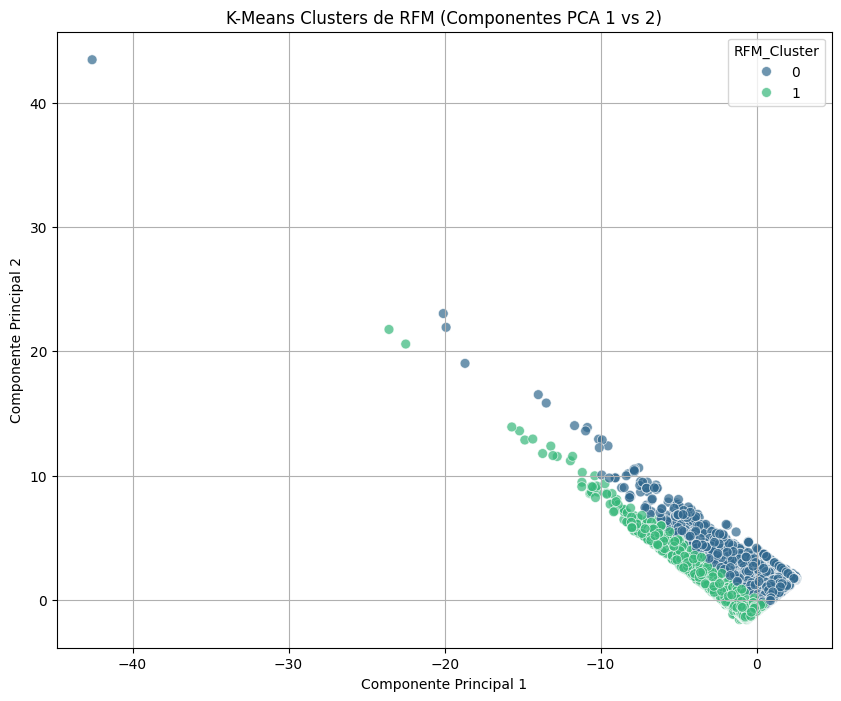

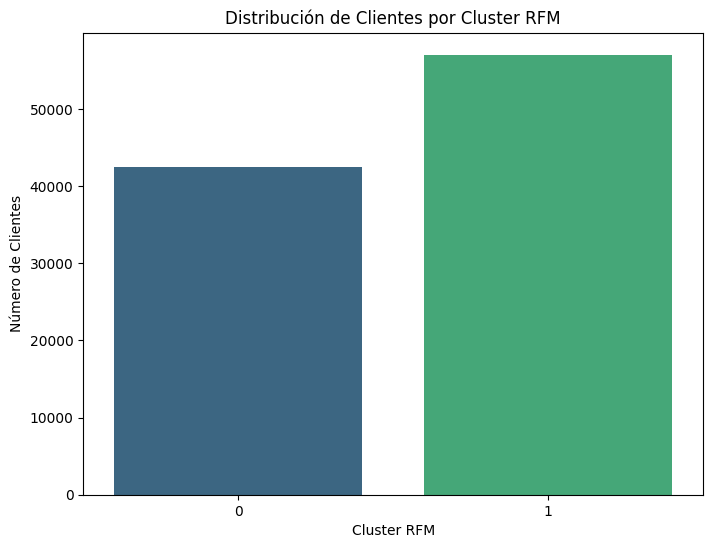

Características promedio de cada cluster RFM:


,RFM_Recency,RFM_Frequency,RFM_Monetary
RFM_Cluster,,,
0,440.301056,1.0,162.729609
1,179.782857,1.0,159.703758


Tamaño de cada cluster RFM:


,count
RFM_Cluster,
0,42414
1,57027


In [93]:
# Definir el número de clusters
num_clusters_rfm = 2


# Inicializar y ajustar el modelo K-Means
kmeans_rfm_final = KMeans(
    n_clusters=num_clusters_rfm,
    n_init=10,
    max_iter=300,
    random_state=42
)


kmeans_rfm_final.fit(pca_result_rfm)


# Asignar las etiquetas de cluster a los datos originales de customer_rfm
customer_rfm['RFM_Cluster'] = kmeans_rfm_final.labels_


print(f"K-Means clustering aplicado con {num_clusters_rfm} clusters a los datos RFM (PCA-transformados).")
print("Primeras filas del DataFrame de clientes con etiquetas de cluster:")
display(customer_rfm.head())


# Visualización de los clusters en los dos primeros componentes principales de PCA de RFM
plt.figure(figsize=(10, 8))
sns.scatterplot(x=pca_result_rfm[:, 0], y=pca_result_rfm[:, 1], hue=customer_rfm['RFM_Cluster'], palette='viridis', legend='full', s=50, alpha=0.7)
plt.title('K-Means Clusters de RFM (Componentes PCA 1 vs 2)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid(True)
plt.show()


# Visualización de la distribución de clientes por cluster
plt.figure(figsize=(8, 6))
sns.countplot(x='RFM_Cluster', data=customer_rfm, hue='RFM_Cluster', palette='viridis', legend=False)
plt.title('Distribución de Clientes por Cluster RFM')
plt.xlabel('Cluster RFM')
plt.ylabel('Número de Clientes')
plt.show()


# Analizar las características promedio de cada cluster
cluster_means = customer_rfm.groupby('RFM_Cluster')[['RFM_Recency', 'RFM_Frequency', 'RFM_Monetary']].mean()
print("Características promedio de cada cluster RFM:")
display(cluster_means)


# Si quieres ver el tamaño de cada cluster
cluster_sizes = customer_rfm['RFM_Cluster'].value_counts().sort_index()
print("Tamaño de cada cluster RFM:")
display(cluster_sizes)


# Test de hipotesis

## Hipotesis 1

In [96]:

import numpy as np
import pandas as pd
from scipy import stats


# ---- Config ----
vars_to_test = ["RFM_Recency", "RFM_Frequency", "RFM_Monetary"]
cluster_col = "RFM_Cluster"
c0, c1 = 0, 1   # los dos clusters a comparar


# ---- Helpers de tamaño de efecto ----
def cohens_d(x, y):
    x = np.asarray(x); y = np.asarray(y)
    nx, ny = len(x), len(y)
    vx, vy = np.var(x, ddof=1), np.var(y, ddof=1)
    if nx < 2 or ny < 2: return np.nan
    sp2 = ((nx-1)*vx + (ny-1)*vy) / (nx+ny-2)
    return (np.mean(x) - np.mean(y)) / np.sqrt(sp2) if sp2 > 0 else np.nan


def cliffs_delta(x, y):
    # |delta| interpreta magnitud: 0.147 (pequeño), 0.33 (mediano), 0.474 (grande)
    x = np.asarray(x); y = np.asarray(y)
    nx, ny = len(x), len(y)
    if nx == 0 or ny == 0: return np.nan
    # más eficiente que doble bucle para muestras grandes: usar ranking
    ranks = stats.rankdata(np.concatenate([x, y]))
    rx = ranks[:nx].sum()
    # delta = (2*rx - nx*(nx+1)) / (nx*ny) - 1  -> corrección:
    delta = (2*rx - nx*(nx+1)) / (nx*ny) - 1
    return delta


# ---- Reporte tamaños de cluster (como pasaste) ----
print("Tamaño de cada cluster:")
print(customer_rfm.groupby(cluster_col).size())


# ---- Loop de variables ----
results = []
for v in vars_to_test:
    print("\n" + "="*70)
    print(f"Variable: {v}")


    x = customer_rfm.loc[customer_rfm[cluster_col] == c0, v].dropna()
    y = customer_rfm.loc[customer_rfm[cluster_col] == c1, v].dropna()


    # Chequeo: si la varianza es 0 en alguno → no se puede comparar con t ni MWU
    if x.nunique() <= 1 or y.nunique() <= 1:
        print("⚠️ Alguno de los grupos es constante → no se puede testear diferencia (varianza=0).")
        print(f"Medias: C{c0}={x.mean():.4f}, C{c1}={y.mean():.4f}")
        results.append([v, "Constante", np.nan, np.nan, np.nan, np.nan, np.nan])
        continue


    # 1) Normalidad (como en tu ejemplo: normaltest)
    p_norm_x = stats.normaltest(x).pvalue if len(x) >= 8 else np.nan
    p_norm_y = stats.normaltest(y).pvalue if len(y) >= 8 else np.nan
    print(f"Normalidad (D’Agostino–Pearson): p_C{c0}={p_norm_x:.3g}, p_C{c1}={p_norm_y:.3g}")


    # 2) Homogeneidad de varianzas (Levene) – solo informativo
    p_levene = stats.levene(x, y, center='median').pvalue
    print(f"Levene (varianzas iguales): p={p_levene:.3g}")


    # 3) Elegir test
    normal_ok = (p_norm_x is not np.nan and p_norm_x >= 0.05) and (p_norm_y is not np.nan and p_norm_y >= 0.05)


    if normal_ok:
        # t-test Welch por defecto (robusto si varianzas difieren)
        tstat, p_t = stats.ttest_ind(x, y, equal_var=False)
        d = cohens_d(x, y)
        print(f"t de Student (Welch): t={tstat:.3f}, p={p_t:.3g}, Cohen's d={d:.3f}")
        test_used = "t-Welch"
        stat, pval, eff, eff_name = tstat, p_t, d, "Cohen's d"
    else:
        # No normalidad → Mann–Whitney U
        u, p_u = stats.mannwhitneyu(x, y, alternative="two-sided")
        delta = cliffs_delta(x, y)
        print(f"Mann–Whitney U: U={u:.0f}, p={p_u:.3g}, Cliff's δ={delta:.3f}")
        test_used = "Mann–Whitney"
        stat, pval, eff, eff_name = u, p_u, delta, "Cliff's δ"


    # 4) Resumen
    print(f"Medias: C{c0}={x.mean():.3f}, C{c1}={y.mean():.3f} | Medianas: C{c0}={x.median():.3f}, C{c1}={y.median():.3f}")
    results.append([v, test_used, stat, pval, eff_name, eff, p_levene])


# DataFrame resumen
cols = ["Variable", "Test", "Estadístico", "p-valor", "Efecto", "Magnitud", "p-Levene"]
res_df = pd.DataFrame(results, columns=cols).sort_values("p-valor")
print("\nResumen comparaciones 0 vs 1:")
print(res_df.to_string(index=False))

Tamaño de cada cluster:
RFM_Cluster
0    42414
1    57027
dtype: int64

Variable: RFM_Recency
Normalidad (D’Agostino–Pearson): p_C0=0, p_C1=0
Levene (varianzas iguales): p=0
Mann–Whitney U: U=2418704350, p=0, Cliff's δ=1.000
Medias: C0=440.301, C1=179.783 | Medianas: C0=427.000, C1=182.000

Variable: RFM_Frequency
⚠️ Alguno de los grupos es constante → no se puede testear diferencia (varianza=0).
Medias: C0=1.0000, C1=1.0000

Variable: RFM_Monetary
Normalidad (D’Agostino–Pearson): p_C0=0, p_C1=0
Levene (varianzas iguales): p=0.00445
Mann–Whitney U: U=1201487413, p=0.0782, Cliff's δ=-0.007
Medias: C0=162.730, C1=159.704 | Medianas: C0=104.010, C1=106.530

Resumen comparaciones 0 vs 1:
     Variable         Test  Estadístico  p-valor    Efecto  Magnitud  p-Levene
  RFM_Recency Mann–Whitney 2418704349.5 0.000000 Cliff's δ  0.999968  0.000000
 RFM_Monetary Mann–Whitney 1201487413.0 0.078233 Cliff's δ -0.006519  0.004446
RFM_Frequency    Constante          NaN      NaN       NaN       NaN  

## Hipotesis 3

In [97]:
fact_orders.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'customer_lat', 'customer_lng', 'customer_geo_city',
       'customer_geo_state', 'payment_value_total', 'payment_installments_max',
       'payment_type_mode', 'review_score', 'review_creation_date',
       'review_answer_timestamp', 'delivery_days', 'is_late',
       'yeojohnson_payment_value_total',
       'z_score_payment_value_total_yeojohnson', 'z_score_payment_value_total',
       'payment_value_total_orig', 'yeojohnson_delivery_days',
       'z_score_delivery_days_yeojohnson', 'z_score_delivery_days',
       'delivery_days_orig', 'delivery_delay'],
      dtype='object')

In [98]:
import numpy as np
import pandas as pd
from scipy import stats


# === Asumo que ya tenés el DataFrame: fact_orders ===
# columnas relevantes: 'review_score', 'delivery_days'


# 0) Filtro y preparación
df = fact_orders.copy()


# Mantener filas válidas para ambos campos
df = df[['review_score', 'delivery_days']].dropna()


# Review binario para grupos (≤3 vs >3)
df['review_le3'] = (df['review_score'] <= 3).astype(int)


# Grupos
x = df.loc[df['review_le3'] == 1, 'delivery_days']  # grupo reviews ≤ 3
y = df.loc[df['review_le3'] == 0, 'delivery_days']  # grupo reviews > 3


print(f"N (≤3): {len(x)}, N (>3): {len(y)}")


# 1) Normalidad por grupo (D’Agostino–Pearson) — informativo
p_norm_x = stats.normaltest(x).pvalue if len(x) >= 8 else np.nan
p_norm_y = stats.normaltest(y).pvalue if len(y) >= 8 else np.nan
print(f"Normalidad (D’Agostino–Pearson) p (≤3)={p_norm_x:.3g}, p (>3)={p_norm_y:.3g}")


# 2) Test principal: t-Welch si ambas normales; si no, Mann–Whitney U (+ KS 2-samples)
normal_ok = (not np.isnan(p_norm_x) and p_norm_x >= 0.05) and \
            (not np.isnan(p_norm_y) and p_norm_y >= 0.05)


if normal_ok:
    # t de Student con corrección de Welch (varianzas desiguales por defecto)
    tstat, p_t = stats.ttest_ind(x, y, equal_var=False)
    print(f"t de Student (Welch): t={tstat:.3f}, p={p_t:.3g}")
else:
    # Mann–Whitney U (no paramétrico)
    u, p_u = stats.mannwhitneyu(x, y, alternative="two-sided")
    print(f"Mann–Whitney U: U={u:.0f}, p={p_u:.3g}")
    # Comparación de distribuciones completa (opcional, visto en clase)
    ks = stats.ks_2samp(x, y)
    print(f"Kolmogorov–Smirnov 2-muestras: D={ks.statistic:.3f}, p={ks.pvalue:.3g}")


# 3) Resumen de tendencia central (para el reporte)
print(f"Medianas delivery_days:  ≤3 = {x.median():.3f}  |  >3 = {y.median():.3f}")
print(f"Medias delivery_days:    ≤3 = {x.mean():.3f}    |  >3 = {y.mean():.3f}")


# 4) Enfoque B: Asociación monotónica (Spearman) entre demora y rating (1–5)
rho, p_s = stats.spearmanr(df['delivery_days'], df['review_score'])
print(f"Spearman: ρ={rho:.3f}, p={p_s:.3g}")
# Interpretación esperada: ρ < 0 y p pequeño (más días ⇒ peores ratings ⇒ review_score baja)




N (≤3): 22857, N (>3): 76584
Normalidad (D’Agostino–Pearson) p (≤3)=0, p (>3)=0
Mann–Whitney U: U=1171991214, p=0
Kolmogorov–Smirnov 2-muestras: D=0.255, p=0
Medianas delivery_days:  ≤3 = 14.000  |  >3 = 9.000
Medias delivery_days:    ≤3 = 17.385    |  >3 = 10.591
Spearman: ρ=-0.259, p=0


# Exportacion de CSV para Power BI

In [94]:
# Definir patrones de exclusión para las columnas de preprocesamiento
exclusion_patterns = [
    'z_score_', 'boxcox_', 'yeojohnson_', 'cleaned_', 'boxcox_imputed_',
    '_orig', 'review_score_str'
]


# Filtrar las columnas que no coincidan con los patrones de exclusión
columns_to_export = []
for col in fact_orders.columns:
    if not any(pattern in col for pattern in exclusion_patterns):
        columns_to_export.append(col)


# Crear un nuevo DataFrame con solo las columnas deseadas
fact_orders_filtered = fact_orders[columns_to_export].copy()


# Exportar el DataFrame filtrado a CSV
csv_path_filtered = '/content/fact_orders_cleaned.csv'
fact_orders_filtered.to_csv(csv_path_filtered, index=False)


print(f"El DataFrame 'fact_orders_cleaned' (filtrado) ha sido exportado a: {csv_path_filtered}")
print("Columnas exportadas:", fact_orders_filtered.columns.tolist())


# Para verificar el contenido del archivo CSV exportado (opcional)
print("Primeras 5 filas del archivo CSV exportado:")
with open(csv_path_filtered, 'r') as f:
    for i, line in enumerate(f):
        if i >= 5:
            break
        print(line.strip())

El DataFrame 'fact_orders_cleaned' (filtrado) ha sido exportado a: /content/fact_orders_cleaned.csv
Columnas exportadas: ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state', 'customer_lat', 'customer_lng', 'customer_geo_city', 'customer_geo_state', 'payment_value_total', 'payment_installments_max', 'payment_type_mode', 'review_score', 'review_creation_date', 'review_answer_timestamp', 'delivery_days', 'is_late', 'delivery_delay']
Primeras 5 filas del archivo CSV exportado:
order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customer_lat,customer_lng,customer_geo_city,customer_geo_sta

In [95]:
df = pd.read_csv('/content/fact_orders_cleaned.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       99441 non-null  object 
 1   customer_id                    99441 non-null  object 
 2   order_status                   99441 non-null  object 
 3   order_purchase_timestamp       99441 non-null  object 
 4   order_approved_at              99281 non-null  object 
 5   order_delivered_carrier_date   97658 non-null  object 
 6   order_delivered_customer_date  96476 non-null  object 
 7   order_estimated_delivery_date  99441 non-null  object 
 8   customer_unique_id             99441 non-null  object 
 9   customer_zip_code_prefix       99441 non-null  int64  
 10  customer_city                  99441 non-null  object 
 11  customer_state                 99441 non-null  object 
 12  customer_lat                   99441 non-null 